# 0. 환경설정 및 데이터 불러오기

In [1]:
! pip install koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 84.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

In [3]:
data_path = '/content/drive/MyDrive/코드잇_데이터분석_6기/프로젝트/중급 분석 프로젝트/주제 1. 국내 채용시장 및 채용 플랫폼 이용패턴 분석/log_2023.csv'
log_2023_df = pd.read_csv(data_path, index_col=0)

# 1. 로그 데이터 전처리

In [4]:
log_2023_df.shape

(7187783, 6)

In [5]:
log_2023_df.head(3)

,user_uuid,URL,timestamp,date,response_code,method
0,5ce8f5ca-3476-4623-a60c-00c98eef3b62,@user_id,2023-12-29 13:19:50.230356 UTC,2023-12-29,200,GET
1,5ce8f5ca-3476-4623-a60c-00c98eef3b62,api/users/notifications/mark_read?id=6425064&_...,2023-12-29 13:20:17.848762 UTC,2023-12-29,200,GET
2,5ce8f5ca-3476-4623-a60c-00c98eef3b62,jobs/id/id_title,2023-12-29 13:22:22.277796 UTC,2023-12-29,200,GET


## 데이터타입 변경 : date 컬럼 datetime으로

In [6]:
log_2023_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7187783 entries, 0 to 7187782
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   user_uuid      object
 1   URL            object
 2   timestamp      object
 3   date           object
 4   response_code  int64 
 5   method         object
dtypes: int64(1), object(5)
memory usage: 383.9+ MB


In [ ]:
log_2023_df['date'] = pd.to_datetime(log_2023_df['date'])

In [ ]:
log_2023_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7187783 entries, 0 to 7187782
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   user_uuid      object        
 1   URL            object        
 2   timestamp      object        
 3   date           datetime64[ns]
 4   response_code  int64         
 5   method         object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 383.9+ MB


## response code 전처리

In [ ]:
log_2023_df['response_code'].value_counts()

,count
response_code,
200,6760350
302,102499
400,29425
404,14011
409,4834
500,834
405,479
401,475
301,57


```python
2xx : 성공
3xx : 리다이렉션, 요청 완료를 위해 리다이렉션이 이루어져야 한다 (외부 웹서버로 연결되는 등)
4xx : 클라이언트 오류
5xx : 서버 오류

→ 사용자 기록에서의 오류를 제거하기 위해서 4xx, 5xx는 삭제한다
```

In [ ]:
delete_response_code = log_2023_df['response_code'].isin([404, 400, 409, 500, 401, 405, 503, 403])
log_2023_df = log_2023_df[~delete_response_code]

In [ ]:
log_2023_df['response_code'].value_counts()

,count
response_code,
200,6760350
302,102499
301,57


## URL 전처리

### URL nan값 삭제 : 369,434개 행 삭제
- 로그 데이터 분석을 위해서는 URL 값이 필요하고, URL 정보가 없는 로그는 데이터 오류로 판단함

In [ ]:
log_2023_df.dropna(inplace=True)
log_2023_df.isna().sum()

,0
user_uuid,0
URL,0
timestamp,0
date,0
response_code,0
method,0


```python
URL에 보이는 키워드 1차 분류
- 구직자 : /search/, /users/, @user_id, jobs/id/, setting, timeline, recommend, guided action, apply_progress, suggest,
verify, continue?next=/@, help/id, verify_phone, api/job_offer, api/post/id/, remove, api/project/form_data/media,
api/jobs/user_filter/id, user_received, continue?next=/jobs, api/jobs/widget/widget_templates, jobs?specialty=, people?rel=1,
people?keywords=, api/references, api/jobs/collections/template, api/ask-manager/id, jobs?location, api/media/id/form,
api/specialties/id/follow_button, jobs?career_type, api/people/template, /signup/
- 기업 : jobs?page=&job, pricing, api/jobs/form_data/media, api/page/id/form
- 기타 : people, zip_code?index=, api/application_thread_comment/id, app,
password_reset, email_verify\?code=, people\?school, people\?job=1&location=, api/page/id/view, api/page/id/form
```

### admin 제거

<mark> 우리의 분석 타겟은 '유저'이므로 제거 로그에 'admin'이 포함된 것은 제외
- api/search/people/job_title?name=멸치TV A(melchi App) 및 admin관리 시스템 메인 기획 및 운영 매니저&_=1699526824841	이런 로그는 admin일 수도 있고, 기업 담당자일 수도 있으나 '유저'는 아니므로 제거

In [ ]:
condition_admin = log_2023_df['URL'].str.contains('admin')
log_2023_df.loc[condition_admin, 'URL'].value_counts()

,count
URL,
api/search/specialty?name=admin,3
api/search/people/job_title?name=멸치TV App(melchi TV) 및 admin 시스템 메인 기획 및 운영 매니저&_=1699526824845,1
api/search/people/job_title?name=멸치TV App(melchi T) 및 admin관리 시스템 메인 기획 및 운영 매니저&_=1699526824843,1
api/search/people/job_title?name=멸치TV A(melchi App) 및 admin관리 시스템 메인 기획 및 운영 매니저&_=1699526824841,1
api/search/people/job_title?name=멸치TV App(melchi App) 및 admin관리 시스템 메인 기획 및 운영 매니저&_=1699526824842,1
api/search/people/job_title?name=멸치 T어플리케이션(melchi App) 및 admin관리 시스템 메인 기획 및 운영 매니저&_=1699526824837,1
api/search/people/job_title?name=멸치TV어플리케이션(melchi App) 및 admin관리 시스템 메인 기획 및 운영 매니저&_=1699526824839,1
api/search/people/job_title?name=멸치 TV어플리케이션(melchi App) 및 admin관리 시스템 메인 기획 및 운영 매니저&_=1699526824838,1
api/search/people/job_title?name=멸치TV 어플리케이션(melchi App) 및 admin관리 시스템 메인 기획 및 운영 매니저&_=1699526824840,1


In [ ]:
log_2023_df = log_2023_df[~condition_admin]

### company 제거

<mark> 우리의 분석 타겟은 '유저'이므로 명백하게 company인 것은 제외하고 진행

```python
- pricing : 결제와 관련된 선택은 대부분 기업에게
- api/jobs/form_data/media : 채용공고 미디어 수정
- api/companies/id/ad_stat/progress : 광고 관련
- api/page/id/form : 페이지 양식 POST method라 기업
- api/page/id/view : 페이지 뷰 POST method라 기업
- api/people/template : 특정인의 템플릿 보는 것
- api/users/id/request_button : 요청하기 버튼 > 주로 기업이 어떤 사람에 대한 정보 열람 요청 시에 사용
- jobs/id/applications : 직무 지원자 리스트 호출
- api/companies/id/form	: 기업의 정보 입력/수정 폼 로드
```

In [ ]:
pattern_company = (
    'pricing|api/jobs/form_data/media|api/companies/id/ad_stat/progress|api/page/id/view|api/people/template|'
    'api/page/id/form|api/users/id/request_button|jobs/id/applications.*|api/companies/id/form'
)
condition_companies = log_2023_df['URL'].str.contains(pattern_company, regex=True, na=False)

In [ ]:
log_2023_filtering = log_2023_df[~condition_companies]

In [ ]:
log_2023_filtering

,user_uuid,URL,timestamp,date,response_code,method
0,5ce8f5ca-3476-4623-a60c-00c98eef3b62,@user_id,2023-12-29 13:19:50.230356 UTC,2023-12-29,200,GET
1,5ce8f5ca-3476-4623-a60c-00c98eef3b62,api/users/notifications/mark_read?id=6425064&_...,2023-12-29 13:20:17.848762 UTC,2023-12-29,200,GET
2,5ce8f5ca-3476-4623-a60c-00c98eef3b62,jobs/id/id_title,2023-12-29 13:22:22.277796 UTC,2023-12-29,200,GET
3,5ce8f5ca-3476-4623-a60c-00c98eef3b62,suggest?q=epdlxj,2023-12-29 13:21:22.99993 UTC,2023-12-29,200,GET
4,5ce8f5ca-3476-4623-a60c-00c98eef3b62,api/current_guided_action/id,2023-12-29 13:20:19.834724 UTC,2023-12-29,200,POST
...,...,...,...,...,...,...
7187778,167cdb14-d145-4679-b878-66a9a2d32ee9,@user_id,2023-11-14 12:12:26.780872 UTC,2023-11-14,200,GET
7187779,167cdb14-d145-4679-b878-66a9a2d32ee9,@user_id,2023-11-14 12:11:38.859562 UTC,2023-11-14,200,GET
7187780,f5649d90-3016-4747-9924-a05d74ee895e,api/users/id/template,2023-11-14 13:16:19.471324 UTC,2023-11-14,200,POST
7187781,f5649d90-3016-4747-9924-a05d74ee895e,verify_phone?next_url=/%40kkwangpe,2023-11-14 13:16:11.530244 UTC,2023-11-14,200,GET


In [ ]:
# 제거된 log_2023_filtering 안에 아직 남아있는 pattern이 있는지 확인
has_company_pattern = log_2023_filtering['URL'].str.contains(pattern_company).any()

if has_company_pattern:
    print("⚠️ log_2023_filtering에 여전히 pattern_company 조건에 해당하는 URL이 남아 있습니다.")
    # 남아있는 것 확인해보고 싶다면:
    remaining_logs = log_2023_filtering[log_2023_filtering['URL'].str.contains(pattern_company)]
    display(remaining_logs['URL'].unique())
else:
    print("✅ log_2023_filtering에는 pattern_company에 해당하는 URL이 완전히 제거되었습니다.")

✅ log_2023_filtering에는 pattern_company에 해당하는 URL이 완전히 제거되었습니다.


### 'app' url 삭제

<mark> 우리의 비즈니스 목표는 지원서를 완료까지 하게 하는 것이 최종 목표이고, 이것은 PC로 이루어지므로 app 접속은 제외하기로 함

In [ ]:
condition_app = log_2023_df['URL'].isin(['app'])
log_2023_df.loc[condition_app, 'URL'].value_counts()

,count
URL,
app,1876


In [ ]:
log_2023_filtering = log_2023_df[~condition_app]

In [ ]:
log_2023_filtering

,user_uuid,URL,timestamp,date,response_code,method
0,5ce8f5ca-3476-4623-a60c-00c98eef3b62,@user_id,2023-12-29 13:19:50.230356 UTC,2022-06-23,200,GET
1,5ce8f5ca-3476-4623-a60c-00c98eef3b62,api/users/notifications/mark_read?id=6425064&_...,2023-12-29 13:20:17.848762 UTC,2022-06-23,200,GET
2,5ce8f5ca-3476-4623-a60c-00c98eef3b62,jobs/id/id_title,2023-12-29 13:22:22.277796 UTC,2022-06-23,200,GET
3,5ce8f5ca-3476-4623-a60c-00c98eef3b62,suggest?q=epdlxj,2023-12-29 13:21:22.99993 UTC,2022-06-23,200,GET
4,5ce8f5ca-3476-4623-a60c-00c98eef3b62,api/current_guided_action/id,2023-12-29 13:20:19.834724 UTC,2022-06-23,200,POST
...,...,...,...,...,...,...
7187776,167cdb14-d145-4679-b878-66a9a2d32ee9,@user_id,2023-11-14 12:12:39.329363 UTC,2022-02-11,200,GET
7187777,167cdb14-d145-4679-b878-66a9a2d32ee9,api/users/id/timeline?offset=8&order=recent&_=...,2023-11-14 12:13:52.692674 UTC,2022-02-11,200,GET
7187778,167cdb14-d145-4679-b878-66a9a2d32ee9,@user_id,2023-11-14 12:12:26.780872 UTC,2022-02-11,200,GET
7187780,f5649d90-3016-4747-9924-a05d74ee895e,api/users/id/template,2023-11-14 13:16:19.471324 UTC,2022-02-11,200,POST


In [ ]:
# 제거 후에도 'app'이 남아있는지 확인
has_app = log_2023_filtering['URL'].isin(['app']).any()

if has_app:
    print("⚠️ 'app' URL이 아직 log_2023_filtering에 남아 있습니다.")
    print(log_2023_filtering[log_2023_filtering['URL'] == 'app'])
else:
    print("✅ 'app' URL은 log_2023_filtering에서 완전히 제거되었습니다.")

✅ 'app' URL은 log_2023_filtering에서 완전히 제거되었습니다.


## 분석기간 설정 : 2023년 4월~ 2023년 9월
- 기업의 채용공고 업로드가 아주 많거나(연초) 적은 달(연말)은 경향성을 파악함에 있어 왜곡을 가져올 수 있으므로, 해당 기간을 제외한 6개월을 분석기간으로 설정

In [ ]:
log_2023_filtering.shape

(6851570, 6)

In [ ]:
log_2023_filtering = log_2023_filtering[
    (log_2023_filtering['date'].dt.month >= 4) &
    (log_2023_filtering['date'].dt.month <= 9)
]

In [ ]:
log_2023_filtering.shape

(3523549, 6)

## 1차 데이터 추출

In [ ]:
save_path = '/content/drive/MyDrive/코드잇_데이터분석_6기/프로젝트/중급 분석 프로젝트/'
data_name = 'log_2023_filtering.csv'
data_path = save_path + data_name

In [ ]:
log_2023_filtering.to_csv(data_path, index=False)

In [ ]:
data_df = pd.read_csv(data_path, index_col=0)

In [ ]:
data_df.shape

# 2. 퍼널 단계 분류

In [7]:
data_path = '/content/drive/MyDrive/코드잇_데이터분석_6기/프로젝트/중급 분석 프로젝트/log_2023_filtering.csv'
log = pd.read_csv(data_path)

## 1단계 : 방문/진입

```python
[1단계로 분류된 URL]
- setting?utm_source=notification&utm_medium=ema... : 이메일 푸시를 통해 접속
- api/job_offer/ : 오퍼 받는 내용을 확인하기 위해 클릭
- ?user_received : 특정사용자 ID가 이 링크를 받았다는 마케팅 트래킹 정보
- signup : 회원가입
- api/recommend_specialty : 추천 직무 기반 맞춤 공고 보여주기 (탐색 콘텐츠 준비하는 로그)
- api/current_guided_action/id : 유저에게 다음 추천 행동을 반환 (이런 걸 해보세요!)
```

In [8]:
pattern_step1 = 'setting\?utm_source|api/job_offer|user_received|signup|api/recommend_specialty|widget|api/current_guided_action/id'
condition_step1 = log['URL'].str.contains(pattern_step1)
condition_step1.sum()

np.int64(281401)

In [9]:
view_step1 = log.loc[condition_step1, 'URL']

In [ ]:
view_step1.value_counts()

,count
URL,
api/recommend_specialty,351486
api/current_guided_action/id,157707
api/jobs/widget/widget_templates,13523
signup/detail,3422
signup/step2/career,3041
...,...
api/job_offer/id/modal?type=received&_=1700027567906,1
api/job_offer/id/modal?type=received&_=1700027644600,1
api/job_offer/id/modal?type=received&_=1675001393482,1


## 2단계 : 개인 이력서 작성
- 휴대폰, 이메일 인증 등도 해당 단계에서 진행



```python
[2단계로 분류된 URL]
- setting : 구직자가 자신의 환경설정 페이지에 직접 접속
- email_verify?code : 이메일 인증
- api/users/id/specialty, api/users/id/form : 유저가 자신의 정보를 수정하는 로그
- @user_id/resume/step : 이력서를 작성하는 단계 (채용공고와 무관한 자신의 이력서)
- api/users/id/career/id : 자신의 경력에 대해 확인하거나 편집하는 단계
- api/users/id/project : 유저가 자신의 포트폴리오 구성
- api/users/id/resume/step : 자신의 이력서를 작성하는 단계
- @user_id/resume : 유저가 자신의 이력서 보는 행동
- @user_id : 유저의 프로필 확인 (일반적으로 @user_id는 자기 계정을 가리키는 구조로 설계됨)
- api/users/id/ : 유저가 자신의 이력서를 작성,편집,조회하는 활동
- api/guided_action/add : 유저의 프로필에 추가하라는 액션 유도
- api/projects/id/media/add	: 프로젝트에 미디어 파일 더하기
- api/users/id/template : 구직자가 자기 소개서 양식 불러오기
- api/media/id/form : 구직자가 자신의 이미지 파일 업로드
- api/project/form_data/media : 자신의 프로젝트에 대한 미디어 파일 업로드
- api/verify/education/id : POST method를 쓰고 있다면 구직자가 자신의 정보를 수정해서 사이트에 제출하고 검증받는것, 퍼널분석에서 이력서 작성 단계(중간구간)
- verify_phone? : 휴대폰 번호를 인증해야 하는 페이지
```

In [10]:
# 5단계로 들어가야하는데 중복이 되는 조건 (지원서 작성 단계에서 자신의 경험을 수정하는 것)
condition_except_step5 = log['URL'].isin(['api/users/id/experience/form?type=apply'])
condition_except_step5.sum()

np.int64(77161)

In [11]:
pattern_step2 = (
    'email_verify\?code|api/users/id/specialty|api/users/id/form|@user_id/resume/step|api/users/id/career/id|api/users/id/project|'
    'api/users/id/resume/step|@user_id/resume|@user_id|api/users/id|api/guided_action/add|api/projects/id/media/add|api/users/id/template|'
    'api/media/id/form|api/project/form_data/media|api/verify/education/id|verify_phone'
)
condition_step2 = (
    ~condition_step1 & ~condition_except_step5 &
    (log['URL'].str.contains(pattern_step2) | log['URL'].isin(['setting']))
)
condition_step2.sum()

np.int64(958338)

In [12]:
view_step2 = log.loc[condition_step2, 'URL']
view_step2.value_counts()

,count
URL,
api/users/id/template,276723
@user_id,213019
@user_id/applications,69553
api/users/id/specialty,27407
@user_id/resume,25346
...,...
@user_id?action=experience_verify&obj_id=1008589,1
api/users/id/career/template?_=1690768735251,1
api/users/id/career/id/form?_=1690768735254,1


## 3단계 : 탐색

```python
[3단계로 분류된 URL]
- timeline : 구직자의 홈 화면에서 제공되는 개인화된 정보 목록(추천 채용공고, 최근 본 광고, 스크랩한 광고 이런 것들이 보여지는 것)
- suggest?q=생물 : 자동완성 기능으로 '생물'이 제안되는 것(구직자)
- api/jobs/job_title?page=&q= : 채용공고 직무명 리스트 요청 (구직자가 관심 직무 검색 등)
- api/jobs/job_title?keywords= : 채용공고 키워드 요청 (구직자가 검색)
- jobs?specialty=SQL : 구직자가 기술에 sql을 필터링 한 로그
- api/jobs/collections/template : 구직자 맞춤형으로 지원공고가 나오는 로그
- jobs?location=  : 구직자가 지역을 필터링해본것
- api/specialties/id/follow_button : 구직자가 특정 전문분야 팔로우/언팔로우
- api/jobs/user_filter/id : user의 관심 필터를 저장하거나 호출할때
- search/companies : 기업을 검색
- jobs?page=&job=1&salary=60000000-&location=서울특...: 구직자가 조건을 계속 필터링하며 탐색할 때
- jobs, job, companies만 있는 것 : 직무나 회사 필터링해서 검색하거나 클릭(공고 x)
- help/id : 구직자가 도움을 구하는 페이지
- api/post/id/ : 커뮤니티 글에 대한 조회
- people?school : 특정 사람의 학교 확인
- people?job=1&location : 특정 사람의 직무, 주소 탐색
- api/companies/id/view	: 기업의 페이지 탐색
- companies/company_id/jobs	: 특정 기업의 채용공고 탐색
- companies/company_id : 특정 회사의 프로필을 조회
- api/jobs/widget/widget_templates : 채용공고 UI를 어떤 형태로 모여줄지를 위한 템플릿을 불러오는 로그
- api/companies/id/member_list?oneline=1&offset=3 : 특정 기업의 멤버 리스트 조회
- @user_id/job_offer/received : 유저가 받는 제안 목록 확인(스스로 확인하는 것)
- jobs/job_title : 특정 직무의 공고 리스트 보여주기
- @user_id/bookmark	: 유저의 북마크 (job/id/bookmark가 아니기 때문에 기업 등에 대한 북마크로 판단)
- api/search/specialty?name=re : 특정 전문분야를 검색하는 것
- api/companies/id/bookmark	: 특정 기업 북마크
- jobs?job=1 : 채용공고에서 특정 조건 필터링
- api/comapnies/id/follow_button : 특정 회사 팔로우
- api/search/product : 특정 제품이나 서비스를 기준으로 검색
```

In [13]:
pattern_step3 = (
    'timeline|suggest\?q|api/jobs/job_title|jobs\?specialty|api/jobs/collections/template|'
    'jobs\?location|api/specialties/id/follow_button|user_filter|search/companies|jobs\?page=&job|help/id|api/post/id|'
    'people\?school|people\?job=1&location|api/companies/id/view|companies/company_id/jobs|companies/company_id|widget|'
    'api/companies/id/member_list|@user_id/job_offer/received|jobs/job_title|@user_id/bookmark|'
    'api/search/specialty\?name=re|api/companies/id/bookmark|jobs\?job=|api/comapnies/id/follow_button|api/search/product'
)
condition_step3 = (
    ~condition_step1 & ~condition_step2 &
    (log['URL'].str.contains(pattern_step3) | log['URL'].isin(['jobs', 'people', 'companies', 'job']))
)
condition_step3.sum()

np.int64(977269)

In [14]:
view_step3 = log.loc[condition_step3, 'URL']
view_step3.value_counts()

,count
URL,
companies/company_id/jobs,94031
api/companies/id/view,88233
companies/company_id,81063
jobs,70972
api/jobs/job_title?job=1,40001
...,...
api/search/companies?name=외주프로젝트&_=1686541680578,1
api/search/product?name=N&_=1686541680567,1
api/search/companies?name=d&_=1686541680575,1


## 4단계 : 공고 조회 (특정 공고를 클릭)

```python
[4단계로 분류된 URL]
- jobs/id/id_title : 채용공고 클릭
- people?company : 그 회사의 '구성원(people)' 보기 클릭
- people?rel=1 : 특정 회사의 구성원 정보 확인 (기업일 가능성도 있지만 낮음)
- people?keywords=크리낙&q=    : 크리낙이라는 이름으로(아마도 회사) 구성원 찾는 로그
- api/ask-manager/id : 구직자가 매니저(기업담당자)에게 질문하기
- api/jobs/id/other_jobs?offset=0&limit=5 : 현재 보고 있는 공고와 관련된 다른 공고를 불러오는 요청
- api/jobs/id/other_jobs : 관련 공고 불러오기
- jobs/id/bookmark : 특정 공고 북마크
- api/jobs/id/follow_button	: 해당 공고 팔로우
```

In [15]:
pattern_step4 = (
    'jobs/id/id_title|people\?company|people\?rel=1|api/ask-manager/id|api/jobs/id/other_jobs\?offset=0&limit=5|api/jobs/id/other_jobs|'
    'jobs/id/bookmark|api/jobs/id/follow_button'
)
condition_step4 = (
    ~condition_step1 & ~condition_step2 & ~condition_step3 & log['URL'].str.contains(pattern_step4)
)
condition_step4.sum()

np.int64(505955)

In [16]:
view_step4 = log.loc[condition_step4, 'URL']
view_step4.value_counts()

,count
URL,
jobs/id/id_title,244954
api/jobs/id/other_jobs?offset=0&limit=5,182916
api/jobs/id/other_jobs,36141
api/jobs/id/bookmark,20041
jobs/id/id_title?utm_source=notification&utm_medium=email&utm_campaign=&utm_content=view_job,3753
...,...
people?company=136756,1
people?company=172807,1
people?company=177313,1


## 5단계 : 지원서 작성

```python
[5단계로 분류된 URL]
- continue?next=/@didwndckd/applications : 로그인 리디랙션
- continue?next=/jobs/132489/apply/step1&token=1...   : 로그인 후 공고 지원 시작 페이지로 이동하는 로그
- api/references : 지원할 때 추천인과 관련된 로그
- jobs/id/apply/step : 지원서 작성 단계
- api/jobs/id/template_oneclick	: 일종의 '간편지원' 버튼
- api/users/id/experience/form?type=apply : 자신의 경력정보 폼 불러오기(채용공고에서)
```

In [17]:
# 5단계로 들어가야하는데 중복이 되는 조건 (채용공고 단계에서 자신의 경험을 수정하는 것)
condition_except_step5 = log['URL'].isin(['api/users/id/experience/form?type=apply'])
condition_except_step5.sum()

np.int64(77161)

In [18]:
pattern_step5 = (
    'continue\?next=/@|continue\?next=/jobs/|api/references|jobs/id/apply/step|api/jobs/id/template_oneclick'
)
condition_step5 = (
    ~condition_step1 & ~condition_step2 & ~condition_step3 & ~condition_step4 & (log['URL'].str.contains(pattern_step5) | condition_except_step5)
)
condition_step5.sum()

np.int64(379921)

In [19]:
view_step5 = log.loc[condition_step5, 'URL']
view_step5.value_counts()

,count
URL,
api/users/id/experience/form?type=apply,77161
jobs/id/apply/step1,47392
jobs/id/apply/step2,41653
api/jobs/id/apply/step2,37231
api/jobs/id/apply/step1,36785
...,...
continue?next=/@kja2683/activities,1
continue?next=/@jhohkist/job_offer/sent,1
continue?next=/@yj97000/job_offer/sent,1


## 6단계 : 지원 완료

```python
[6단계로 분류된 URL]
- @user_id/applications : 구직자가 지원한 이력 확인
- apply_progress : 지원한 공고의 전형 단계 확인
- api/remove_application/id : 지원서 삭제
- jobs/id/apply/complete : 지원 완료
```

In [20]:
pattern_step6 = '@user_id/applications|apply_progress|api/remove_application/id|jobs/id/apply/complete'
condition_step6 = (
    ~condition_step1 & ~condition_step2 & ~condition_step3 & ~condition_step4 & ~condition_step5 & log['URL'].str.contains(pattern_step6)
)
condition_step6.sum()

np.int64(49576)

In [21]:
view_step6 = log.loc[condition_step6, 'URL']
view_step6.value_counts()

,count
URL,
jobs/id/apply/complete,14010
api/remove_application/id,3977
api/apply_progress?_=1682273405903,2
api/apply_progress?_=1684072370711,1
api/apply_progress?_=1684919244463,1
...,...
api/apply_progress?_=1687330372231,1
api/apply_progress?_=1687330372232,1
api/apply_progress?_=1687330372239,1


# 3. 퍼널 데이터 초안 생성

## 퍼널 데이터 만들기

In [22]:
#1단계
pattern_step1 = 'setting\?utm_source|api/job_offer|user_received|signup|api/recommend_specialty|widget|api/current_guided_action/id'
condition_step1 = log['URL'].str.contains(pattern_step1)
step1 = log[condition_step1]
step1_users = set(step1['user_uuid'])

#2단계
condition_except_step5 = log['URL'].isin(['api/users/id/experience/form?type=apply'])
pattern_step2 = (
    'email_verify\?code|api/users/id/specialty|api/users/id/form|@user_id/resume/step|api/users/id/career/id|api/users/id/project|'
    'api/users/id/resume/step|@user_id/resume|@user_id|api/users/id|api/guided_action/add|api/projects/id/media/add|api/users/id/template|'
    'api/media/id/form|api/project/form_data/media|api/verify/education/id|verify_phone'
)
condition_step2 = (
    ~condition_step1 & ~condition_except_step5 &
    (log['URL'].str.contains(pattern_step2) | log['URL'].isin(['setting']))
)
step2 = log[condition_step2 & log['user_uuid'].isin(step1_users)]
step2_users = set(step2['user_uuid'])

#3단계
pattern_step3 = (
    'timeline|suggest\?q|api/jobs/job_title|jobs\?specialty|api/jobs/collections/template|'
    'jobs\?location|api/specialties/id/follow_button|user_filter|search/companies|jobs\?page=&job|help/id|api/post/id|'
    'people\?school|people\?job=1&location|api/companies/id/view|companies/company_id/jobs|companies/company_id|widget|'
    'api/companies/id/member_list|@user_id/job_offer/received|jobs/job_title|@user_id/bookmark|'
    'api/search/specialty\?name=re|api/companies/id/bookmark|jobs\?job=|api/comapnies/id/follow_button|api/search/product'
)
condition_step3 = (
    ~condition_step1 & ~condition_step2 &
    (log['URL'].str.contains(pattern_step3) | log['URL'].isin(['jobs', 'people', 'companies', 'job']))
)

step3 = log[condition_step3 & log['user_uuid'].isin(step2_users)]
step3_users = set(step3['user_uuid'])

#4단계
pattern_step4 = (
    'jobs/id/id_title|people\?company|people\?rel=1|api/ask-manager/id|api/jobs/id/other_jobs\?offset=0&limit=5|api/jobs/id/other_jobs|'
    'jobs/id/bookmark|api/jobs/id/follow_button'
)
condition_step4 = (
    ~condition_step1 & ~condition_step2 & ~condition_step3 & log['URL'].str.contains(pattern_step4)
)
step4 = log[condition_step4 & log['user_uuid'].isin(step3_users)]
step4_users = set(step4['user_uuid'])

#5단계
condition_except_step5 = log['URL'].isin(['api/users/id/experience/form?type=apply'])
pattern_step5 = (
    'continue\?next=/@|continue\?next=/jobs/|api/references|jobs/id/apply/step|api/jobs/id/template_oneclick'
)
condition_step5 = (
    ~condition_step1 & ~condition_step2 & ~condition_step3 & ~condition_step4 & (log['URL'].str.contains(pattern_step5) | condition_except_step5)
)
step5 = log[condition_step5 & log['user_uuid'].isin(step4_users)]
step5_users = set(step5['user_uuid'])

#6단계
pattern_step6 = '@user_id/applications|apply_progress|api/remove_application/id|jobs/id/apply/complete'
condition_step6 = (
    ~condition_step1 & ~condition_step2 & ~condition_step3 & ~condition_step4 & ~condition_step5 & log['URL'].str.contains(pattern_step6)
)
step6 = log[condition_step6 & log['user_uuid'].isin(step5_users)]
step6_users = set(step6['user_uuid'])

In [23]:
# 로그 단계 설명하는 컬럼 추가
step1['step'] = 'step1'
step2['step'] = 'step2'
step3['step'] = 'step3'
step4['step'] = 'step4'
step5['step'] = 'step5'
step6['step'] = 'step6'

<ipython-input-23-583c55eb8bf8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  step1['step'] = 'step1'
<ipython-input-23-583c55eb8bf8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  step2['step'] = 'step2'
<ipython-input-23-583c55eb8bf8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [24]:
# 퍼널 단계 전체 데이터 합치기
funnel_logs = pd.concat([step1, step2, step3, step4, step5, step6], ignore_index=True)

## 전처리

In [25]:
# timestamp 데이터타입 변경
funnel_logs['timestamp'] = pd.to_datetime(funnel_logs['timestamp'].str.replace(" UTC", "", regex=False), errors='coerce')

In [26]:
funnel_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3082005 entries, 0 to 3082004
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   user_uuid      object        
 1   URL            object        
 2   timestamp      datetime64[ns]
 3   date           object        
 4   response_code  int64         
 5   method         object        
 6   step           object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 164.6+ MB


## 이상치 제거
- 퍼널단계 전체 이용기간이 0분, 6개월 이상인 값 제거

In [27]:
# user_id별로 timestamp 정렬
funnel_logs = funnel_logs.sort_values(['user_uuid', 'timestamp'])

In [28]:
# 유저별로 단계별 체류시간
# .shift(-1): 다음 값을 현재 줄에 넣는 pandas 문법
funnel_logs['next_timestamp'] = funnel_logs.groupby('user_uuid')['timestamp'].shift(-1)

# NaN (이탈 유저의 마지막 단계)은 현재 timestamp로 채워서 time_diff = 0으로 만들기
funnel_logs['next_timestamp'] = funnel_logs['next_timestamp'].fillna(funnel_logs['timestamp'])

# 분 단위로 계산 : dt.total_senconds()에 1분은 60초
funnel_logs['time_diff'] = (funnel_logs['next_timestamp'] - funnel_logs['timestamp']).dt.total_seconds() / 60

# 인덱스 정리
funnel_logs.reset_index(inplace=True)

In [30]:
# 유저별 전체 이용기간
# 유저별 단계별 체류시간(time_diff)의 합
user_whole_time = funnel_logs.groupby('user_uuid')['time_diff'].sum().reset_index()
user_whole_time

,user_uuid,time_diff
0,000b55ad-5c86-438b-a5b0-9ea3a2917789,87211.904712
1,000e8610-16d3-4e9e-bf50-202d191ffac4,161308.084357
2,0017a738-4fcc-441e-983b-a6033890a9db,163952.831272
3,004a89cc-d69b-4336-9905-4fd306e3ef80,211769.184336
4,005d1d8c-2b25-4b4e-a5a3-a1f2a2efe7d2,256962.460043
...,...,...
8964,ffd75368-f7ed-4eaf-9db9-0f76ef80af31,79203.191484
8965,ffd9e595-6d1a-452a-98bb-ff7a1bd8cb40,115173.005234
8966,ffe429f9-200e-472d-9d72-2742727c8ea8,58107.448403
8967,ffe6aee0-85cc-45e2-aa5e-129751dff08e,229330.306191


In [31]:
# 이상치 구하기
outliers = user_whole_time[
    (user_whole_time['time_diff'] == 0) |
    (user_whole_time['time_diff'] >= 259200)
    ]

# 이상치 개수 출력
print(f"이상치의 개수: {outliers.shape[0]}개")

이상치의 개수: 187개


In [32]:
# 이상치에 해당하는 user_uuid를 제외한 데이터만 필터링
filtered_user_whole_time = user_whole_time[~user_whole_time['user_uuid'].isin(outliers['user_uuid'])]

# 결과 확인
print(f"이상치가 제외된 데이터의 개수: {filtered_user_whole_time.shape[0]}개")

이상치가 제외된 데이터의 개수: 8782개


In [33]:
# filtered_user_whole_time에 포함된 user_uuid 목록
valid_user_uuids = filtered_user_whole_time['user_uuid']

# funnel_logs에서 valid_user_uuids에 해당하는 유저만 필터링
filtered_funnel_logs = funnel_logs[funnel_logs['user_uuid'].isin(valid_user_uuids)]

# 결과 확인
print(f"필터링된 funnel_logs의 데이터 개수: {filtered_funnel_logs.shape[0]}")

필터링된 funnel_logs의 데이터 개수: 2945862


In [34]:
print(f"기존 funnel_logs에서 {funnel_logs.shape[0]-filtered_funnel_logs.shape[0]:,}개 user_uuid 제거됨")

기존 funnel_logs에서 136,143개 user_uuid 제거됨


In [35]:
filtered_funnel_logs.shape

(2945862, 10)

In [ ]:
# 데이터 추출
save_path = '/content/drive/MyDrive/코드잇_데이터분석_6기/프로젝트/중급 분석 프로젝트/'
data_name = 'filtered_funnel_logs_logs.csv'
data_path = save_path + data_name
filtered_funnel_logs.to_csv(data_path, index=False)

# 4. 1단계 세그먼트 분류 및 최종 퍼널 데이터 생성

In [36]:
data_path = '/content/drive/MyDrive/코드잇_데이터분석_6기/프로젝트/중급 분석 프로젝트/filtered_funnel_logs_logs.csv'
log = pd.read_csv(data_path, index_col=0)

## 1단계 세그먼트 분류

In [37]:
# signup 유저, joboffer 유저, 마케팅 경로 접속 유저, 단순 접속 유저로 구분

pattern_step1_signup = 'signup'
pattern_step1_joboffer = 'api/job_offer'
pattern_step1_marketing = 'setting\?utm_source|user_received'
pattern_step1_etc = 'api/recommend_specialty|widget|api/current_guided_action/id'

condition_signup = log['URL'].str.contains(pattern_step1_signup)
condition_joboffer = log['URL'].str.contains(pattern_step1_joboffer)
condition_marketing = log['URL'].str.contains(pattern_step1_marketing)
condition_etc = log['URL'].str.contains(pattern_step1_etc)

log['step1_segment'] = np.select([condition_signup, condition_joboffer, condition_marketing, condition_etc],
                                 ['signup', 'joboffer', 'marketing', 'etc'], default='none')

In [38]:
log['step1_segment'].value_counts()

,count
step1_segment,
none,2672240
etc,257219
signup,11657
joboffer,3447
marketing,1299


In [39]:
# signup 유저만 필터링
log_from_signup = log[log['step1_segment'].isin(['signup', 'none'])]
log_from_signup

,user_uuid,URL,timestamp,date,response_code,method,step,next_timestamp,time_diff,step1_segment
index,,,,,,,,,,
152198,000b55ad-5c86-438b-a5b0-9ea3a2917789,signup/detail,2023-06-21 11:01:34.663903,2023-06-21,302,GET,step1,2023-06-21 11:01:34.772232,0.001805,signup
152191,000b55ad-5c86-438b-a5b0-9ea3a2917789,signup/step1/name,2023-06-21 11:01:34.772232,2023-06-21,200,GET,step1,2023-06-21 11:01:52.901332,0.302152,signup
152184,000b55ad-5c86-438b-a5b0-9ea3a2917789,signup/step2/career,2023-06-21 11:01:52.901332,2023-06-21,200,GET,step1,2023-06-21 11:01:54.763335,0.031033,signup
824221,000b55ad-5c86-438b-a5b0-9ea3a2917789,api/users/id/image,2023-06-21 11:02:01.742970,2023-06-21,200,POST,step2,2023-06-21 11:02:05.062977,0.055333,none
824224,000b55ad-5c86-438b-a5b0-9ea3a2917789,api/users/id/profile_image,2023-06-21 11:02:05.062977,2023-06-21,200,POST,step2,2023-06-21 11:02:05.347628,0.004744,none
...,...,...,...,...,...,...,...,...,...,...
392606,ffeba6fd-76b6-41cc-8535-de3d9d86e079,@user_id/resume,2023-08-25 07:27:34.925770,2023-08-25,200,GET,step2,2023-09-16 16:35:44.277917,32228.155869,none
2232533,ffeba6fd-76b6-41cc-8535-de3d9d86e079,jobs/id/id_title,2023-09-16 16:35:44.277917,2023-09-17,200,GET,step4,2023-09-18 00:32:21.818474,1916.625676,none
392598,ffeba6fd-76b6-41cc-8535-de3d9d86e079,api/users/id/card2/template,2023-09-18 00:32:21.818474,2023-09-18,200,GET,step2,2023-09-18 00:32:23.798002,0.032992,none


## 1단계 signup 유저 대상, 순서대로 이행한 유저 퍼널 도출

In [40]:
log_steps = log_from_signup.dropna(subset=['step']).sort_values(['user_uuid', 'timestamp'])
user_step_seq = log_steps.groupby('user_uuid')['step'].apply(list).reset_index()

valid_funnel = ['step1', 'step2', 'step3', 'step4', 'step5', 'step6']

# 순서대로 잘 가다가 중간에 멈춘 유저 → 포함 예) ['step1', 'step2'] → OK
# 순서 꼬인 유저 → 제외 예) ['step1', 'step3', 'step2'] → X
# step1조차 없는 유저 → 제외

def is_ordered_prefix(seq, valid_funnel):
    index = 0
    for step in seq:
        if index < len(valid_funnel) and step == valid_funnel[index]:
            index += 1
        elif step in valid_funnel[index:]:
            # 올바르지 않은 순서로 다음 step 등장 → 탈락
            return False
    return index > 0  # 최소 step1은 있어야 유효

user_step_seq['valid'] = user_step_seq['step'].apply(lambda x: is_ordered_prefix(x, valid_funnel))

# 조건에 맞는 유저만 필터
strict_users = set(user_step_seq[user_step_seq['valid']]['user_uuid'])
strict_log = log_from_signup[log_from_signup['user_uuid'].isin(strict_users)]

In [41]:
strict_log.shape

(221895, 10)

In [42]:
strict_log.head(2)

,user_uuid,URL,timestamp,date,response_code,method,step,next_timestamp,time_diff,step1_segment
index,,,,,,,,,,
225279,00b43208-7cc2-4a35-b8fb-73baa3258dcf,signup/detail,2023-05-07 15:34:34.078864,2023-05-08,302,GET,step1,2023-05-07 15:34:34.186563,0.001795,signup
225311,00b43208-7cc2-4a35-b8fb-73baa3258dcf,signup/step1/name,2023-05-07 15:34:34.186563,2023-05-08,200,GET,step1,2023-05-07 15:34:39.194408,0.083464,signup


In [43]:
#1단계
pattern_step1 = 'setting\?utm_source|api/job_offer|user_received|signup|api/recommend_specialty|widget|api/current_guided_action/id'
condition_step1 = strict_log['URL'].str.contains(pattern_step1)
step1 = strict_log[condition_step1]
step1_users = set(step1['user_uuid'])

#2단계
condition_except_step5 = strict_log['URL'].isin(['api/users/id/experience/form?type=apply'])
pattern_step2 = (
    'email_verify\?code|api/users/id/specialty|api/users/id/form|@user_id/resume/step|api/users/id/career/id|api/users/id/project|'
    'api/users/id/resume/step|@user_id/resume|@user_id|api/users/id|api/guided_action/add|api/projects/id/media/add|api/users/id/template|'
    'api/media/id/form|api/project/form_data/media|api/verify/education/id|verify_phone'
)
condition_step2 = (
    ~condition_step1 & ~condition_except_step5 &
    (strict_log['URL'].str.contains(pattern_step2) | strict_log['URL'].isin(['setting']))
)
step2 = strict_log[condition_step2 & strict_log['user_uuid'].isin(step1_users)]
step2_users = set(step2['user_uuid'])

#3단계
pattern_step3 = (
    'timeline|suggest\?q|api/jobs/job_title|jobs\?specialty|api/jobs/collections/template|'
    'jobs\?location|api/specialties/id/follow_button|user_filter|search/companies|jobs\?page=&job|help/id|api/post/id|'
    'people\?school|people\?job=1&location|api/companies/id/view|companies/company_id/jobs|companies/company_id|widget|'
    'api/companies/id/member_list|@user_id/job_offer/received|jobs/job_title|@user_id/bookmark|'
    'api/search/specialty\?name=re|api/companies/id/bookmark|jobs\?job=|api/comapnies/id/follow_button|api/search/product'
)
condition_step3 = (
    ~condition_step1 & ~condition_step2 &
    (strict_log['URL'].str.contains(pattern_step3) | strict_log['URL'].isin(['jobs', 'people', 'companies', 'job']))
)

step3 = strict_log[condition_step3 & strict_log['user_uuid'].isin(step2_users)]
step3_users = set(step3['user_uuid'])

#4단계
pattern_step4 = (
    'jobs/id/id_title|people\?company|people\?rel=1|api/ask-manager/id|api/jobs/id/other_jobs\?offset=0&limit=5|api/jobs/id/other_jobs|'
    'jobs/id/bookmark|api/jobs/id/follow_button'
)
condition_step4 = (
    ~condition_step1 & ~condition_step2 & ~condition_step3 & strict_log['URL'].str.contains(pattern_step4)
)
step4 = strict_log[condition_step4 & strict_log['user_uuid'].isin(step3_users)]
step4_users = set(step4['user_uuid'])

#5단계
condition_except_step5 = strict_log['URL'].isin(['api/users/id/experience/form?type=apply'])
pattern_step5 = (
    'continue\?next=/@|continue\?next=/jobs/|api/references|jobs/id/apply/step|api/jobs/id/template_oneclick'
)
condition_step5 = (
    ~condition_step1 & ~condition_step2 & ~condition_step3 & ~condition_step4 & (strict_log['URL'].str.contains(pattern_step5) | condition_except_step5)
)
step5 = strict_log[condition_step5 & strict_log['user_uuid'].isin(step4_users)]
step5_users = set(step5['user_uuid'])

#6단계
pattern_step6 = '@user_id/applications|apply_progress|api/remove_application/id|jobs/id/apply/complete'
condition_step6 = (
    ~condition_step1 & ~condition_step2 & ~condition_step3 & ~condition_step4 & ~condition_step5 & strict_log['URL'].str.contains(pattern_step6)
)
step6 = strict_log[condition_step6 & strict_log['user_uuid'].isin(step5_users)]
step6_users = set(step6['user_uuid'])

# 5. 퍼널 분석 기초

## 단계별 로그 수

In [44]:
print(f'1단계(방문,진입) 로그 수 : {step1.shape[0]:,}')
print(f'2단계(이력서 작성) 로그 수 : {step2.shape[0]:,}')
print(f'3단계(탐색) 로그 수 : {step3.shape[0]:,}')
print(f'4단계(공고 조회) 로그 수 : {step4.shape[0]:,}')
print(f'5단계(지원서 작성) 로그 수 : {step5.shape[0]:,}')
print(f'6단계(지원 완료) 로그 수 : {step6.shape[0]:,}')

1단계(방문,진입) 로그 수 : 4,826
2단계(이력서 작성) 로그 수 : 75,545
3단계(탐색) 로그 수 : 66,397
4단계(공고 조회) 로그 수 : 33,732
5단계(지원서 작성) 로그 수 : 36,347
6단계(지원 완료) 로그 수 : 5,048


## 단계별 고유 유저 수

In [45]:
print(f'1단계 유저 수 : {len(step1_users):,}')
print(f'2단계 유저 수 : {len(step2_users):,}')
print(f'3단계 유저 수 : {len(step3_users):,}')
print(f'4단계 유저 수 : {len(step4_users):,}')
print(f'5단계 유저 수 : {len(step5_users):,}')
print(f'6단계 유저 수 : {len(step6_users):,}')

1단계 유저 수 : 539
2단계 유저 수 : 496
3단계 유저 수 : 488
4단계 유저 수 : 426
5단계 유저 수 : 385
6단계 유저 수 : 371


## 단계별 전환율, 이탈률

In [46]:
# 단계별 사용자 수 리스트로 정리
step_user_sets = [step1_users, step2_users, step3_users, step4_users, step5_users, step6_users]
step_user_counts = [len(users) for users in step_user_sets]

for i in range(1, len(step_user_counts)):
    prev = step_user_counts[i - 1]
    curr = step_user_counts[i]

    # 전환율
    conversion_rate = (curr / prev * 100) if prev else 0

    # 이탈률
    dropoff_rate = ((prev - curr) / prev * 100) if prev else 0

    print(f"{i} → {i+1}단계 전환율: {conversion_rate:.2f}%, 이탈률: {dropoff_rate:.2f}%")

1 → 2단계 전환율: 92.02%, 이탈률: 7.98%
2 → 3단계 전환율: 98.39%, 이탈률: 1.61%
3 → 4단계 전환율: 87.30%, 이탈률: 12.70%
4 → 5단계 전환율: 90.38%, 이탈률: 9.62%
5 → 6단계 전환율: 96.36%, 이탈률: 3.64%


In [ ]:
# 데이터 추출
save_path = '/content/drive/MyDrive/코드잇_데이터분석_6기/프로젝트/중급 분석 프로젝트/'
data_name = 'log_signup_filtering.csv'
data_path = save_path + data_name
strict_log.to_csv(data_path, index=False)

# 6. 퍼널 단계별 현황 분석

In [47]:
data_path = '/content/drive/MyDrive/코드잇_데이터분석_6기/프로젝트/중급 분석 프로젝트/strict_log.csv'
log = pd.read_csv(data_path)

## 퍼널 2단계 관련

### 가설 1) 자신의 이력서에 대한 확인 및 수정이 잦은 유저의 경우, 이탈률이 낮을 것이다
- 2단계 로그가 많이 찍힌 유저일 수록 이탈률이 낮을 것이다

In [48]:
# 2단계 로그 수를 기준으로 유저를 그룹화
step2_segment = step2.groupby('user_uuid')['step'].count().reset_index()
step2_segment.columns = ['user_uuid', 'step2_count']
step2_segment.describe()

,step2_count
count,496.000000
mean,152.308468
std,167.258971
min,1.000000
25%,40.000000
50%,103.000000
75%,207.000000
max,1451.000000


In [49]:
# Step2 로그 수 기준으로 그룹화
# qcut : 4분위수 기준으로 구분
step2_segment['segment'] = pd.qcut(step2_segment['step2_count'], q=3, labels=['low', 'mid', 'high'])

In [50]:
# 고유유저가 도달한 최대 단계 계산
user_max_step = log.groupby('user_uuid')['step'].max().reset_index()
user_max_step.columns = ['user_uuid', 'max_step']
user_max_step['max_step'].value_counts()

,count
max_step,
step6,371
step3,62
step1,43
step4,41
step5,14
step2,8


In [51]:
user_max_step['max_step'].value_counts()

,count
max_step,
step6,371
step3,62
step1,43
step4,41
step5,14
step2,8


In [52]:
# 세그먼트와 이탈 여부 합치기
merged = pd.merge(step2_segment, user_max_step, on='user_uuid', how='inner')

# 세그먼트별로 max_step 분포 보기
merged['segment'].value_counts()

,count
segment,
high,166
low,165
mid,165


In [53]:
# 세그먼트별로 최종 도달 단계 비율 비교
# pd.crosstab() : 두 개의 컬럼을 기준으로 빈도표(교차표)를 만들어주는 함수, pd.crosstab(row, column)
# normalize='index' : 각 행 기준으로 비율(%)로 바꾸는 것

pivot = pd.crosstab(merged['segment'], merged['max_step'], normalize='index')
pivot

max_step,step2,step3,step4,step5,step6
segment,,,,,
low,0.048485,0.248485,0.206061,0.036364,0.460606
mid,0.000000,0.115152,0.036364,0.024242,0.824242
high,0.000000,0.012048,0.006024,0.024096,0.957831


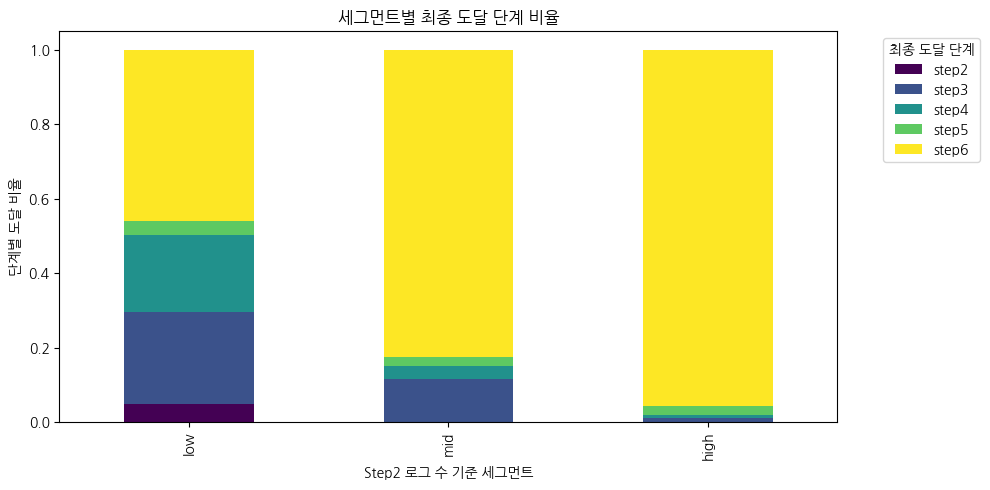

In [54]:
# 시각화
pivot.plot(kind='bar', stacked=True, figsize=(10, 5), colormap='viridis')

plt.title('세그먼트별 최종 도달 단계 비율')
plt.xlabel('Step2 로그 수 기준 세그먼트')
plt.ylabel('단계별 도달 비율')
plt.legend(title='최종 도달 단계', bbox_to_anchor=(1.05, 1), loc='upper left')  # 범례 정렬
plt.tight_layout()
plt.show()

```python
💡 세그먼트가 높아질수록 이탈률이 낮고, 최종 단계 도달률이 높다
💡 특히, low 그룹은 step3~step4 단계에서 대부분 이탈하고, high 그룹은 step6까지 가는 비율이 95%
💡 자신의 이력서에 대한 화인, 수정 빈도가 높을 유저일 수록 최종 단계에 도달하는 비율이 높다
```

### 가설 2) 개인 이력서에 대한 직접적인 입력/수정 로그가 많을수록 최종 단계에 도달할 확률이 높다
- 가설1과 달리 이력서에 대한 직접적인 기재, 수정 로그가 있어야함

In [135]:
# 이력서/포트폴리오 관련 로그 수 확인
resume_logs = strict_log[strict_log["URL"].str.contains("resume|portfolio", na=False)]
print("이력서/포트폴리오 관련 전체 로그 수:", len(resume_logs))

이력서/포트폴리오 관련 전체 로그 수: 7754


In [137]:
# step4(공고 클릭) & step6(지원 완료) 로그 추출
click_logs = strict_log[strict_log["step"] == "step4"].copy()
apply_logs = strict_log[strict_log["step"] == "step6"].copy()

# 유저별 최초 클릭 & 지원 시간 계산
click_time_df = click_logs.groupby("user_uuid")["timestamp"].min().reset_index()
click_time_df.rename(columns={"timestamp": "click_time"}, inplace=True)

apply_time_df = apply_logs.groupby("user_uuid")["timestamp"].min().reset_index()
apply_time_df.rename(columns={"timestamp": "apply_time"}, inplace=True)

# 병합 후 시간차 계산
click_to_apply_df = pd.merge(click_time_df, apply_time_df, on="user_uuid", how="inner")
click_to_apply_df["click_time"] = pd.to_datetime(click_to_apply_df["click_time"], errors="coerce")
click_to_apply_df["apply_time"] = pd.to_datetime(click_to_apply_df["apply_time"], errors="coerce")
click_to_apply_df["click_to_apply_time"] = (
    (click_to_apply_df["apply_time"] - click_to_apply_df["click_time"]).dt.total_seconds() / 60
)

In [139]:
# ① 전체 체류 시간 계산
explore_time = (
    strict_log.groupby("user_uuid")["time_diff"]
    .sum().reset_index().rename(columns={"time_diff": "explore_time_total"})
)
# ② step6 도달 여부
step6_users = strict_log[strict_log["step"] == "step6"]["user_uuid"].unique()
explore_time["step6_도달"] = explore_time["user_uuid"].isin(step6_users).astype(int)

# ③ 최종 도달 퍼널 단계
final_step = (
    strict_log.sort_values(["user_uuid", "timestamp"])
    .groupby("user_uuid")["step"].last().reset_index().rename(columns={"step": "final_step"})
)

# ④ 이력서/포트폴리오 수정 횟수
resume_edit_count = (
    strict_log[strict_log["URL"].str.contains("resume|portfolio", na=False)]
    .groupby("user_uuid").size().reset_index(name="resume_edit_count")
)

# ⑤ 유저 기반 마스터 테이블 병합
user_step_df = (
    explore_time
    .merge(final_step, on="user_uuid", how="left")
    .merge(resume_edit_count, on="user_uuid", how="left")
    .merge(click_to_apply_df[["user_uuid", "click_to_apply_time"]], on="user_uuid", how="left")
)

# ⑥ 결측값 처리
user_step_df["resume_edit_count"] = user_step_df["resume_edit_count"].fillna(0).astype(int)

In [140]:
# 1. 이력서 관련 로그 (resume 관련 URL 포함)
resume_keywords = ['resume', 'career', 'project', 'template', 'experience']
resume_logs = strict_log[strict_log['URL'].str.contains('|'.join(resume_keywords), na=False)]

resume_edit_count = resume_logs.groupby('user_uuid').size().reset_index(name='resume_edit_count')

# 2. 탐색 단계 총 체류시간 (step3에서만)
explore_logs = strict_log[strict_log['step'] == 'step3']
explore_time_total = explore_logs.groupby('user_uuid')['time_diff'].sum().reset_index(name='explore_time_total')

# 3. 클릭 후 지원까지 걸린 시간
click_to_apply_df.columns = ['user_uuid', 'click_to_apply_time', 'click_time', 'apply_time']

# 4. 유저별 최종 도달 퍼널 단계
final_step = strict_log.groupby('user_uuid')['step'].last().reset_index(name='final_step')

# 5. 병합하여 user_step_df 생성
from functools import reduce

dfs_to_merge = [resume_edit_count, explore_time_total, click_to_apply_df, final_step]
user_step_df = reduce(lambda left, right: pd.merge(left, right, on='user_uuid', how='outer'), dfs_to_merge)

# 확인
display(user_step_df.head())

# ✅ step6 도달 여부 부여
step6_users = strict_log[strict_log["step"] == "step6"]["user_uuid"].unique()
user_step_df["step6_도달"] = user_step_df["user_uuid"].isin(step6_users).astype(int)

,user_uuid,resume_edit_count,explore_time_total,click_to_apply_time,click_time,apply_time,final_step
0,00b43208-7cc2-4a35-b8fb-73baa3258dcf,119.0,10453.232235,2023-05-10 04:00:40.090802,2023-05-13 08:18:50.445919,4578.172585,step2
1,00ce67ff-d189-4f0e-80e2-2d5eaa78016e,4.0,0.895559,NaT,NaT,NaN,step4
2,01949f74-ad02-4a43-b0ed-b882c815e985,58.0,5903.238746,NaT,NaT,NaN,step2
3,0195dd12-81f8-4849-89c7-8ab8b8c4c1de,184.0,10907.759676,2023-07-14 10:16:30.191496,2023-07-14 10:23:23.872510,6.894684,step2
4,019f0119-44ca-4b4c-a918-36cca6e99ff7,21.0,0.647122,2023-06-20 03:42:18.212733,2023-06-20 03:43:15.592095,0.956323,step2


In [141]:
# 이력서 로그가 있는 user_uuid 수
resume_user_set = set(resume_logs["user_uuid"].unique())
print("이력서 관련 로그를 가진 고유 유저 수:", len(resume_user_set))

# user_step_df에 포함된 유저 중 얼마나 resume 로그를 갖고 있는가?
step_user_set = set(user_step_df["user_uuid"].unique())
print("user_step_df에 포함된 유저 수:", len(step_user_set))

# 교집합
print("이력서 로그 + 분석 대상 유저 교집합 수:", len(resume_user_set & step_user_set))

이력서 관련 로그를 가진 고유 유저 수: 518
user_step_df에 포함된 유저 수: 539
이력서 로그 + 분석 대상 유저 교집합 수: 518


              count  도달자 수  전환율(%)
resume_group                      
0회               24      3   12.50
1~2회             33     14   42.42
3~4회             31     15   48.39
5회 이상           379    339   89.45

📊 이력서 수정 횟수 그룹 vs Step6 도달 여부 교차표:
step6_도달       0    1
resume_group         
0회            21    3
1~2회          19   14
3~4회          16   15
5회 이상         40  339

✅ 카이제곱 통계량: 135.08
🎓 자유도: 3
📌 유의확률(p-value): 0.00000


<ipython-input-148-f3d2bc0ce1c2>:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



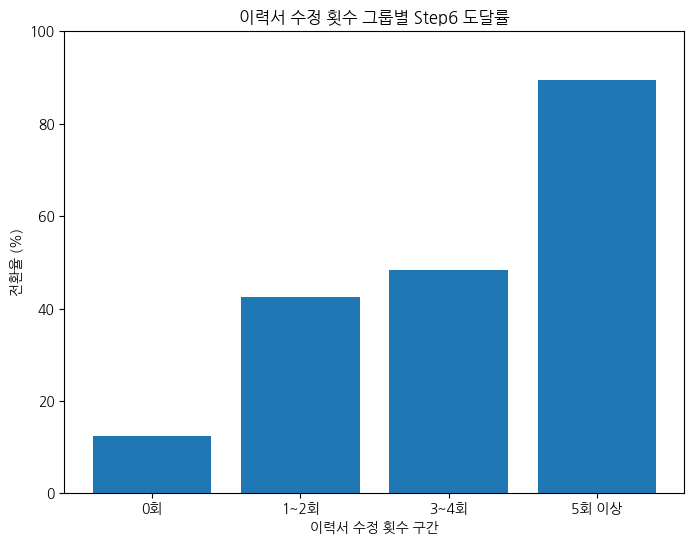

In [148]:
from scipy.stats import chi2_contingency

# ① 이력서 수정 횟수 구간 분류
# bins = [0, 1, 3, 5, float("inf")]
bins = [5, 10, 20, 30, float("inf")]
labels = ["0회", "1~2회", "3~4회", "5회 이상"]
user_step_df["resume_group"] = pd.cut(user_step_df["resume_edit_count"], bins=bins, labels=labels, right=False)

# ② groupby로 전환율 계산
group_summary = (
    user_step_df.groupby("resume_group")["step6_도달"]
    .agg(["count", "sum"])
    .rename(columns={"sum": "도달자 수"})
)
group_summary["전환율(%)"] = (group_summary["도달자 수"] / group_summary["count"] * 100).round(2)
print(group_summary)

# ③ 교차표 생성
contingency_table = pd.crosstab(user_step_df["resume_group"], user_step_df["step6_도달"])
print("\n📊 이력서 수정 횟수 그룹 vs Step6 도달 여부 교차표:")
print(contingency_table)

# ④ 카이제곱 검정
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"\n✅ 카이제곱 통계량: {chi2:.2f}")
print(f"🎓 자유도: {dof}")
print(f"📌 유의확률(p-value): {p:.5f}")

# ⑤ 시각화
plt.figure(figsize=(8, 6))
plt.bar(group_summary.index, group_summary["전환율(%)"])
plt.title("이력서 수정 횟수 그룹별 Step6 도달률")
plt.ylabel("전환율 (%)")
plt.ylim(0, 100)
plt.xlabel("이력서 수정 횟수 구간")
plt.show()

In [149]:
# 🎯 이력서 수정 로그 보유 유저만 추출
resume_users = user_step_df[user_step_df["user_uuid"].isin(resume_user_set)].copy()

# 🧠 이력서 수정 횟수 기준 그룹화
def categorize_resume_count(x):
    if x == 0:
        return "0회"
    elif x <= 2:
        return "1~2회"
    elif x <= 4:
        return "3~4회"
    else:
        return "5회 이상"

resume_users["resume_group"] = resume_users["resume_edit_count"].fillna(0).apply(categorize_resume_count)

# 📊 그룹별 도달률 요약
resume_summary = (
    resume_users.groupby("resume_group")["step6_도달"]
    .agg(["count", "sum"])
    .rename(columns={"sum": "도달자 수"})
)
resume_summary["전환율(%)"] = (resume_summary["도달자 수"] / resume_summary["count"] * 100).round(2)

# 📈 카이제곱 검정
contingency_table = pd.crosstab(resume_users["resume_group"], resume_users["step6_도달"])
chi2, p, dof, expected = chi2_contingency(contingency_table)

In [150]:
# 표 출력
display(resume_summary)

# 교차표 출력
print("📊 이력서 수정 횟수 그룹 vs Step6 도달 여부 교차표:")
print(contingency_table)

# 검정 결과
print(f"\n✅ 카이제곱 통계량: {chi2:.2f}")
print(f"🎓 자유도: {dof}")
print(f"📌 유의확률(p-value): {p:.5f}")

,count,도달자 수,전환율(%)
resume_group,,,
1~2회,33,0,0.00
3~4회,18,0,0.00
5회 이상,467,371,79.44


📊 이력서 수정 횟수 그룹 vs Step6 도달 여부 교차표:
step6_도달       0    1
resume_group         
1~2회          33    0
3~4회          18    0
5회 이상         96  371

✅ 카이제곱 통계량: 142.77
🎓 자유도: 2
📌 유의확률(p-value): 0.00000


## 퍼널 3단계 관련

### 가설) 3단계 체류시간(탐색시간)이 짧을수록 다음단계로의 전환이 낮다

In [82]:
# 이탈자id 데이터
droupoff_3 = step3_users - step4_users
len(droupoff_3)

# 이탈자만 있는 데이터
log_dropoff_3 = step3[step3['user_uuid'].isin(droupoff_3)]
# 이탈자 테이블 시간순으로 재정렬
log_dropoff_3 = log_dropoff_3.sort_values('timestamp',ascending=True)

In [90]:
step3_dropoff_users = step3_users - step4_users
step3_survivor_users = step3_users & step4_users

step3_user_time = log[log['step']=='step3'].groupby('user_uuid')['time_diff'].mean().reset_index(name='avg_time_diff')

step3_user_time['group'] = step3_user_time['user_uuid'].apply(
    lambda x: 'dropoff' if x in step3_dropoff_users else(
        'survivor' if x in step3_survivor_users else 'other'
    )
)

In [92]:
# 페이지 체류시간
log_dropoff = log_dropoff_3.sort_values(['user_uuid','timestamp'])
log_dropoff['next_timestamp'] = log_dropoff.groupby('user_uuid')['timestamp'].shift(-1)
log_dropoff['stay_duration'] = (log_dropoff['next_timestamp'] - log_dropoff['timestamp']).dt.total_seconds()

# 극단적으로 긴값들 제거후 관측
q25 = step3_user_time['avg_time_diff'].quantile(0.25)
filtered_step3 = step3_user_time[step3_user_time['avg_time_diff'] <= q25]

In [88]:
filtered_step3

,user_uuid,avg_time_diff
1,00ce67ff-d189-4f0e-80e2-2d5eaa78016e,0.099507
4,019f0119-44ca-4b4c-a918-36cca6e99ff7,0.040445
8,03fe56ca-7b4b-4587-b878-cd4cca19209e,0.213546
12,074c92ea-a0c4-4981-871e-9cb93df7d7f1,0.232667
23,0c01a336-de37-46be-802d-355094bbf8ae,0.117142
...,...,...
476,fad59989-61d3-4cf9-9756-37891c41def6,0.028619
477,fadd7420-5c59-43ec-b1e4-932c34d0a450,0.135786
480,fc978916-204f-4168-adb7-921cb0310d17,0.201358
484,fd84195e-9b4e-420f-94fb-570167156151,0.259692


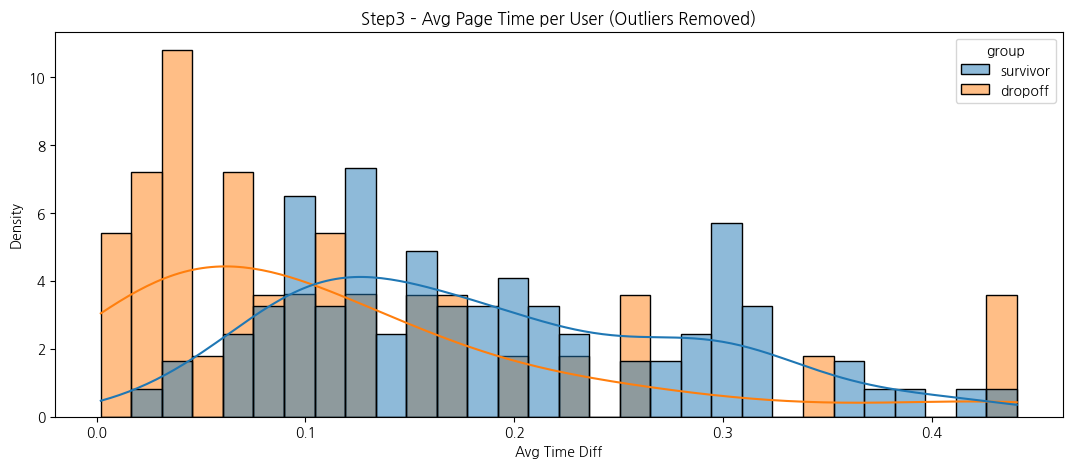

In [93]:
plt.figure(figsize=(13, 5))
sns.histplot(data=filtered_step3, x='avg_time_diff', hue='group', bins=30, kde=True, stat='density', common_norm=False)
plt.title('Step3 – Avg Page Time per User (Outliers Removed)')
plt.xlabel('Avg Time Diff')
plt.ylabel('Density')
plt.show()

In [95]:
# 이상치를 제거하지않은 데이터(전체 step3 데이터)에서 전환자와 이탈자간의 체류시간차이
# 비모수 검정
# 가설: 이탈자의 체류시간이 전환자의 체류시간보다 유의미하게 짧다

from scipy.stats import mannwhitneyu

# dropoff / survivor 그룹 데이터 추출
dropoff = step3_user_time[step3_user_time['group'] == 'dropoff']['avg_time_diff']
survivor = step3_user_time[step3_user_time['group'] == 'survivor']['avg_time_diff']

# Mann-Whitney U 검정 실행
stat, p_value = mannwhitneyu(dropoff, survivor, alternative='less')

# 결과 출력
print(f"Mann-Whitney U 통계량: {stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("→ 이탈자의 체류시간이 전환자의 체류시간보다 통계적으로 유의미하게 짧습니다.")
else:
    print("→ 이탈자의 체류시간이 전환자의 체류시간보다 통계적으로 유의미하게 짧지 않습니다")

Mann-Whitney U 통계량: 6965.0000
p-value: 0.0000
→ 이탈자의 체류시간이 전환자의 체류시간보다 통계적으로 유의미하게 짧습니다.


## 퍼널 4단계 관련

### 가설1) 4단계 체류시간(탐색시간)이 짧을수록 다음단계로의 전환이 낮다

In [131]:
# 이탈률이 가장 큰 4 -> 5 단계에서
# 공고클릭수와 다음단계전환율 비교
step4_job_click = log[(log['URL'].str.contains('jobs/id/id_title', na=False)) & (log['step'] == 'step4')]
click_counts = step4_job_click.groupby('user_uuid').size().reset_index(name='job_click_counts')

step4_users = set(log[log['step'] =='step4']['user_uuid'])
step5_users = set(log[log['step'] == 'step5']['user_uuid'])
dropoff_users = step4_users - step5_users

click_counts['is_dropoff'] = click_counts['user_uuid'].apply(lambda x: 'dropoff' if x in dropoff_users else 'survivor')

# 평균 비교
print(click_counts.groupby('is_dropoff')['job_click_counts'].describe())

            count       mean        std  min    25%   50%    75%    max
is_dropoff                                                             
dropoff      36.0   8.722222  12.300084  1.0   1.75   3.5  10.00   64.0
survivor    380.0  42.739474  48.924345  1.0  11.00  24.0  56.25  292.0


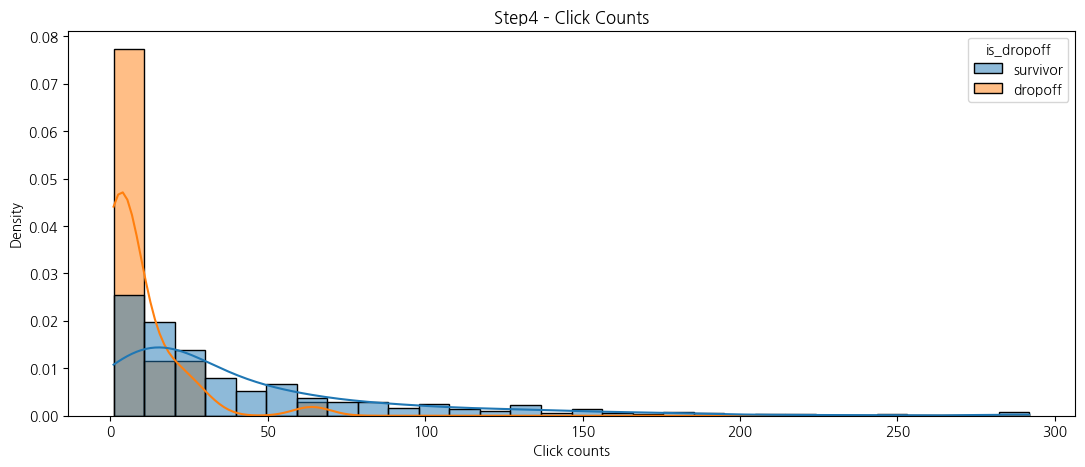

In [132]:
# 클릭률 그래프
plt.figure(figsize=(13, 5))
sns.histplot(data=click_counts, x='job_click_counts', hue='is_dropoff',
             bins=30, kde=True, stat='density', common_norm=False)
plt.title('Step4 – Click Counts')
plt.xlabel('Click counts')
plt.ylabel('Density')
plt.show()

In [133]:
# 이상치를 제거하지않은 데이터(전체 step4 데이터)에서 전환자와 이탈자간의 클릭수차이
# 비모수 검정

# 가설: 이탈자의 클릭 수가 전환자의 클릭 수보다 유의미하게 적다

# dropoff / survivor 그룹 데이터 추출
dropoff = click_counts[click_counts['is_dropoff'] == 'dropoff']['job_click_counts']
survivor = click_counts[click_counts['is_dropoff'] == 'survivor']['job_click_counts']

# Mann-Whitney U 검정 실행
stat, p_value = mannwhitneyu(dropoff, survivor, alternative='less')

# 결과 출력
print(f"Mann-Whitney U 통계량: {stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("→ 이탈자의 클릭 수가 전환자의 클릭 수보다 유의미하게 적다")
else:
    print("→ 이탈자의 클릭 수가 전환자의 클릭 수보다 유의미하게 적지 않다")

Mann-Whitney U 통계량: 2294.5000
p-value: 0.0000
→ 이탈자의 클릭 수가 전환자의 클릭 수보다 유의미하게 적다


### 가설2) 지원 공고에 대한 클릭이 잦은 유저의 경우, 이탈률이 낮을 것이다

In [69]:
# 지원 공고에 대한 클릭 URL을 가진 로그만 필터링
jobclick_condition = step4['URL'].str.contains('jobs/id/id_title')
step4_jobclick = step4[(jobclick_condition)]

In [70]:
# 로그 수 기준으로 그룹화
step4_jobclick_segment = step4_jobclick.groupby('user_uuid')['step'].count().reset_index()
step4_jobclick_segment.columns = ['user_uuid', 'step4_count']
step4_jobclick_segment

,user_uuid,step4_count
0,00b43208-7cc2-4a35-b8fb-73baa3258dcf,12
1,00ce67ff-d189-4f0e-80e2-2d5eaa78016e,7
2,01949f74-ad02-4a43-b0ed-b882c815e985,6
3,0195dd12-81f8-4849-89c7-8ab8b8c4c1de,26
4,019f0119-44ca-4b4c-a918-36cca6e99ff7,1
...,...,...
411,fd0891f1-cef0-4ac1-a1ec-9b5281b491ed,11
412,fd84195e-9b4e-420f-94fb-570167156151,12
413,fe58075f-8d5f-41be-b65d-245c29015133,18
414,febf8553-5efb-404c-91c1-105653f08ffd,1


In [71]:
# 지원공고 클릭 수를 기준으로 세그먼트 분류
step4_jobclick_segment['segment'] = pd.qcut(step4_jobclick_segment['step4_count'], q=3, labels=['low', 'mid', 'high'])
step4_jobclick_segment.head(2)

,user_uuid,step4_count,segment
0,00b43208-7cc2-4a35-b8fb-73baa3258dcf,12,low
1,00ce67ff-d189-4f0e-80e2-2d5eaa78016e,7,low


In [72]:
# 기존 최고 단계 데이터와 합치기
merged = pd.merge(step4_jobclick_segment, user_max_step, on='user_uuid', how='inner')
merged['segment'].value_counts()

,count
segment,
low,141
high,139
mid,136


In [73]:
# 세그먼트별 최종 도달 단계 비교
pivot = pd.crosstab(merged['segment'], merged['max_step'], normalize='index')
pivot

max_step,step4,step5,step6
segment,,,
low,0.191489,0.042553,0.765957
mid,0.058824,0.022059,0.919118
high,0.007194,0.021583,0.971223


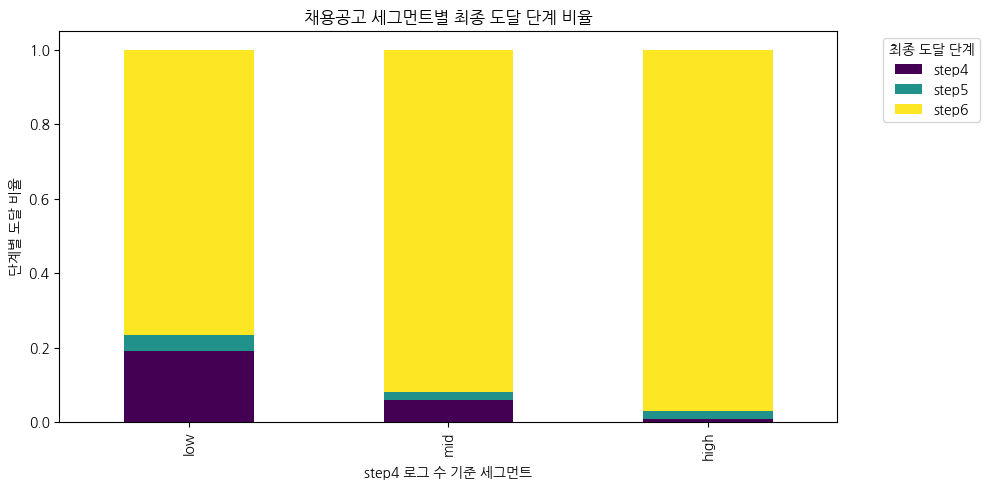

In [74]:
# 시각화
pivot.plot(kind='bar', stacked=True, figsize=(10, 5), colormap='viridis')
plt.title('채용공고 세그먼트별 최종 도달 단계 비율')
plt.xlabel('step4 로그 수 기준 세그먼트')
plt.ylabel('단계별 도달 비율')
plt.legend(title='최종 도달 단계', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

```python
💡 세그먼트가 높아질수록 이탈률이 낮고, 최종 단계 도달률이 높다
💡 채용공고에 대한 클릭이 많은 유저일수록 최종 단계에 도달하는 비율이 높다
✅ 채용공고에 대한 클릭 수는 매우 강력한 예측 변수
🤔 당연해보이긴 하지만, 검증했다는 것에 의의!
```

### 가설3) 관련 공고 불러오기를 클릭한 유저의 경우, 이탈률이 낮을 것이다

In [75]:
# 해당 URL 로그만 필터링
otherjobs_condition = step4['URL'].str.contains('jobs/id/other_jobs')
step4_otherjobs = step4[otherjobs_condition]
step4_otherjobs

,user_uuid,URL,timestamp,date,response_code,method,step,next_timestamp,time_diff,step1_segment
index,,,,,,,,,,
2592228,00b43208-7cc2-4a35-b8fb-73baa3258dcf,api/jobs/id/other_jobs?offset=0&limit=5,2023-05-10 04:02:17.506116,2023-05-10,200,GET,step4,2023-05-10 04:02:26.422300,0.148603,none
2592223,00b43208-7cc2-4a35-b8fb-73baa3258dcf,api/jobs/id/other_jobs?offset=0&limit=5,2023-05-13 08:17:46.968730,2023-05-13,200,GET,step4,2023-05-13 08:18:20.784754,0.563600,none
2592224,00b43208-7cc2-4a35-b8fb-73baa3258dcf,api/jobs/id/other_jobs?offset=0&limit=5,2023-05-13 08:23:46.906053,2023-05-13,200,GET,step4,2023-05-13 08:23:49.655805,0.045829,none
2592214,00b43208-7cc2-4a35-b8fb-73baa3258dcf,api/jobs/id/other_jobs?offset=0&limit=5,2023-05-17 02:44:29.386371,2023-05-17,200,GET,step4,2023-05-17 02:44:39.938731,0.175873,none
2592218,00b43208-7cc2-4a35-b8fb-73baa3258dcf,api/jobs/id/other_jobs?offset=0&limit=5,2023-05-17 02:45:20.926296,2023-05-17,200,GET,step4,2023-05-17 02:45:37.356900,0.273843,none
...,...,...,...,...,...,...,...,...,...,...
2603313,fef719f7-de24-4126-a599-ca2872306f8e,api/jobs/id/other_jobs?offset=0&limit=5,2023-05-31 09:20:48.556541,2023-05-31,200,GET,step4,2023-05-31 09:21:09.931954,0.356257,none
2603311,fef719f7-de24-4126-a599-ca2872306f8e,api/jobs/id/other_jobs?offset=0&limit=5,2023-05-31 09:21:10.308232,2023-05-31,200,GET,step4,2023-05-31 09:21:28.509501,0.303354,none
2603319,fef719f7-de24-4126-a599-ca2872306f8e,api/jobs/id/other_jobs?offset=0&limit=5,2023-05-31 09:22:59.022544,2023-05-31,200,GET,step4,2023-05-31 09:28:52.234424,5.886865,none


In [76]:
# 로그 수 기준으로 그룹화
step4_otherjobs_segment = step4_otherjobs.groupby('user_uuid')['step'].count().reset_index()
step4_otherjobs_segment.columns = ['user_uuid', 'step4_count']
step4_otherjobs_segment.describe()

,step4_count
count,411.00000
mean,36.86618
std,44.48989
min,1.00000
25%,8.00000
50%,20.00000
75%,48.50000
max,291.00000


In [77]:
# step4 로그 수 기준으로 세그먼트
step4_otherjobs_segment['segment'] = pd.qcut(step4_otherjobs_segment['step4_count'], q=3, labels=['low', 'mid', 'high'])
step4_otherjobs_segment.head(2)

,user_uuid,step4_count,segment
0,00b43208-7cc2-4a35-b8fb-73baa3258dcf,10,low
1,00ce67ff-d189-4f0e-80e2-2d5eaa78016e,6,low


In [78]:
# 최고단계 데이터와 합치기
merged = pd.merge(step4_otherjobs_segment, user_max_step, on='user_uuid', how='inner')
merged['segment'].value_counts()

,count
segment,
low,144
high,137
mid,130


In [79]:
# 세그먼트별 최종 단계 도달 비율 비교
pivot = pd.crosstab(merged['segment'], merged['max_step'], normalize='index')
pivot

max_step,step4,step5,step6
segment,,,
low,0.166667,0.048611,0.784722
mid,0.061538,0.030769,0.907692
high,0.007299,0.014599,0.978102


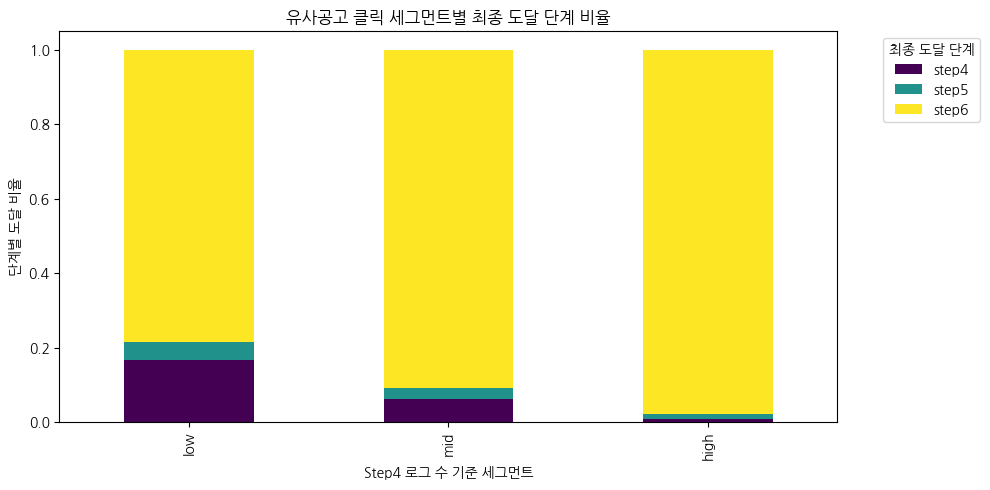

In [80]:
# 시각화
pivot.plot(kind='bar', stacked=True, figsize=(10, 5), colormap='viridis')
plt.title('유사공고 클릭 세그먼트별 최종 도달 단계 비율')
plt.xlabel('Step4 로그 수 기준 세그먼트')
plt.ylabel('단계별 도달 비율')
plt.legend(title='최종 도달 단계', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 7. 유저 여정 기반 패턴 분석

## 유저별 URL 시퀀스 정리

In [96]:
log['timestamp'] = pd.to_datetime(log['timestamp'].str.replace(" UTC", "", regex=False), errors='coerce')

In [97]:
# 1) 유저별 URL 흐름 정리
user_flow = log.sort_values(by=['user_uuid', 'timestamp'])
# 2) 유저별 URL 시퀀스를 리스트로 만들기
user_url_step_path = user_flow.groupby('user_uuid').apply(lambda x: list(zip(x['step'], x['URL'], x['timestamp']))).reset_index(name='url_path')
user_url_step_path

<ipython-input-97-9cbfad7ba5ea>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_url_step_path = user_flow.groupby('user_uuid').apply(lambda x: list(zip(x['step'], x['URL'], x['timestamp']))).reset_index(name='url_path')


,user_uuid,url_path
0,00b43208-7cc2-4a35-b8fb-73baa3258dcf,"[(step1, signup/detail, 2023-05-07 15:34:34.07..."
1,00ce67ff-d189-4f0e-80e2-2d5eaa78016e,"[(step1, signup/detail, 2023-09-20 07:07:48.42..."
2,01949f74-ad02-4a43-b0ed-b882c815e985,"[(step1, signup/detail, 2023-05-03 04:23:58.22..."
3,0195dd12-81f8-4849-89c7-8ab8b8c4c1de,"[(step1, signup/detail, 2023-06-29 13:28:22.58..."
4,019f0119-44ca-4b4c-a918-36cca6e99ff7,"[(step1, signup/detail, 2023-06-20 03:39:41.20..."
...,...,...
534,fd84195e-9b4e-420f-94fb-570167156151,"[(step1, signup/detail, 2023-08-26 07:57:23.41..."
535,fe58075f-8d5f-41be-b65d-245c29015133,"[(step1, signup/detail, 2023-04-04 00:24:36.89..."
536,febf8553-5efb-404c-91c1-105653f08ffd,"[(step1, signup/detail, 2023-08-31 04:00:46.24..."
537,fef719f7-de24-4126-a599-ca2872306f8e,"[(step1, signup/detail, 2023-05-20 09:20:28.50..."


## 6단계 도달 유저

In [98]:
completed_users = user_url_step_path[user_url_step_path['url_path'].apply(lambda x:any(step == 'step6' for step, URL, timestamp in x))]
completed_users

,user_uuid,url_path
0,00b43208-7cc2-4a35-b8fb-73baa3258dcf,"[(step1, signup/detail, 2023-05-07 15:34:34.07..."
3,0195dd12-81f8-4849-89c7-8ab8b8c4c1de,"[(step1, signup/detail, 2023-06-29 13:28:22.58..."
4,019f0119-44ca-4b4c-a918-36cca6e99ff7,"[(step1, signup/detail, 2023-06-20 03:39:41.20..."
7,030d7868-eced-4a3a-82f8-4f493ce1b7c1,"[(step1, signup/detail, 2023-07-18 01:54:05.76..."
8,03a430f7-6799-405a-aada-fb0e55beb02b,"[(step1, signup/step2/career, 2023-04-25 23:23..."
...,...,...
531,fd057cbd-bb99-4a6b-b722-7078a53ca8c6,"[(step1, signup/detail, 2023-05-04 15:57:33.80..."
532,fd0891f1-cef0-4ac1-a1ec-9b5281b491ed,"[(step1, signup/detail, 2023-08-03 11:45:08.62..."
534,fd84195e-9b4e-420f-94fb-570167156151,"[(step1, signup/detail, 2023-08-26 07:57:23.41..."
535,fe58075f-8d5f-41be-b65d-245c29015133,"[(step1, signup/detail, 2023-04-04 00:24:36.89..."


### 랜덤 샘플링

In [99]:
# random sampling을 통해 유저의 여정 확인
# .sample(1) : 무작위로 1행 뽑기
sample_user = completed_users.sample(1).iloc[0]
sample_user

,436
user_uuid,d076977b-3e47-40b0-ae79-0fe897224951
url_path,"[(step1, signup/detail, 2023-04-12 04:04:18.30..."


In [100]:
for step, url, timestamp in sample_user['url_path']:
     print(f"{timestamp} | {step}: {url}")

2023-04-12 04:04:18.301472 | step1: signup/detail
2023-04-12 04:04:19.599558 | step1: signup/step1/name
2023-04-12 04:04:27.143450 | step1: signup/step2/career
2023-04-12 04:04:37.196487 | step2: api/users/id/image
2023-04-12 04:04:50.666839 | step2: api/users/id/profile_image
2023-04-12 04:04:50.927063 | step1: api/signup/form
2023-04-12 04:04:51.447887 | step1: api/signup/form
2023-04-12 04:05:07.293343 | step3: api/search/companies?name=없음&_=1681272264905
2023-04-12 04:05:07.738597 | step3: api/search/companies?name=없음&_=1681272264906
2023-04-12 04:05:11.493152 | step3: api/search/companies?name=없음&_=1681272264909
2023-04-12 04:05:22.868715 | step2: api/users/id/specialty
2023-04-12 04:05:24.897010 | step2: api/users/id/specialty
2023-04-12 04:05:27.338654 | step2: api/users/id/specialty
2023-04-12 04:05:33.178440 | step2: api/users/id/specialty
2023-04-12 04:05:39.338143 | step2: api/users/id/specialty
2023-04-12 04:05:42.218476 | step2: api/users/id/specialty
2023-04-12 04:05:46.0

### 로그 수 기준 25%, 50%, 75% user

In [101]:
# 각 유저의 로그 수 계산
completed_users['log_count'] = completed_users['url_path'].apply(len)

# 로그 수 기준 퍼센타일 유저 선택
# .value를 붙이면 Series 형식을 Numpy 배열로 변경
percentiles = [0.25, 0.5, 0.75]
quantile_values = completed_users['log_count'].quantile(percentiles).values

<ipython-input-101-71e92f1bdac3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completed_users['log_count'] = completed_users['url_path'].apply(len)


In [102]:
# 각 퍼센타일에 해당하는 log_count 값과 가장 가까운 유저 선택
selected_users = []
for value in quantile_values:
    # 절대값 차이가 가장 적은 유저 1명 선택
    # .abs() : 절대값으로 거리를 계산
    # .argsort() : 절대값 기준으로 오름차순 정렬한 인덱스 순서를 반환
    # [:1] : 그중 가장 가까운 유저 1명만 선택
    closest_user = completed_users.iloc[(completed_users['log_count']-value).abs().argsort()[:1]]
    selected_users.append(closest_user)

In [103]:
selected_users[1]

,user_uuid,url_path,log_count
113,35610806-1e6e-4b1e-98a0-4db54ac1d61d,"[(step1, signup/detail, 2023-06-07 06:26:06.38...",419


In [104]:
# 결과정리 및 저장
selected_df = pd.concat(selected_users).drop_duplicates(subset='user_uuid')
selected_user_flows = {}

# .iterrows() : DF를 한 줄씩 돌면서 row로 가져오는 반복문
# _는 인덱스인데 사용하지 않아서 무시한 것
for _, row in selected_df.iterrows():
    user_id = row['user_uuid']
    url_path = row['url_path']
    selected_user_flows[user_id] = url_path
    print(f"\n=== {user_id} ({len(url_path)} logs) ===")
    for step, url, timestamp in url_path:
        print(f"{timestamp} | {step}: {url}")


=== 14ffe69c-c66d-4ec1-aa7c-b14f60310500 (240 logs) ===
2023-08-01 06:07:30.979944 | step1: signup/detail
2023-08-01 06:07:31.068336 | step1: signup/step1/name
2023-08-01 06:07:48.449666 | step1: signup/step2/career
2023-08-01 06:08:17.382710 | step2: api/users/id/specialty
2023-08-01 06:08:24.890853 | step2: api/users/id/specialty
2023-08-01 06:08:29.876543 | step2: api/users/id/specialty
2023-08-01 06:08:33.698328 | step2: api/users/id/specialty
2023-08-01 06:08:37.145019 | step2: api/users/id/specialty
2023-08-01 06:08:44.536995 | step2: api/users/id/specialty
2023-08-01 06:08:57.869020 | step3: api/search/companies?name=없음&_=1690870068258
2023-08-01 06:09:01.664143 | step3: api/search/companies?name=없음&_=1690870068259
2023-08-01 06:09:04.363483 | step3: api/search/companies?name=한국대학새&_=1690870068260
2023-08-01 06:09:04.602914 | step3: api/search/companies?name=한국대학생&_=1690870068261
2023-08-01 06:09:05.292792 | step3: api/search/companies?name=한국대학생선교회&_=1690870068262
2023-08-01 0

```python
로그 수 25% 수준의 유저 행동 패턴
🧾 요약 (Summary)
- 총 로그 수 : 240개
- 이용 기간 : 8월 1일 ~ 9월 27일

🔍 퍼널 흐름 분석
- step3에서 company_id/job에 대한 로그가 많은 편
- 특정 회사, 직무, 사람에 대한 탐색이 잦은 것으로 보아 희망하는 공고가 나올 때까지 적극 탐색하는 것으로 보임

🗓️ 날짜별 로그
- 8월 1일, 약 23분 접속 : 최초 접속 및 회원가입 후, 직무 검색, 회사 검색, 특정 조건(지역, 직무 이름 등)을 넣는 검색 진행했고 채용 공고를 클릭한 후 유사공고까지 확인
- 8월 24일, 약 3분 접속 : 포트폴리오 작성, 직무 탐색, 공고 확인, 유사공고 확인 진행
- 8월 25일, 1분 접속 : 특정 회사의 직무, 채용 공고 확인
- 9월 5일, 약 16분 접속 : 포트폴리오 작성, 사람 검색, 직무 검색, 채용공고 확인, 유사공고 확인, 북마크 진행 >
- 9월 13일, 약 15분 접속 : 지역 조건 걸고 직무 탐색, 채용공고 확인, 지원서 작성 1단계 진입 후 다시 개인 포트폴리오로 복귀, 특정 상품 및 회사 검색, 포트폴리오 수정
											  지원서 단계별 작성, 지원 완료
- 9월 14일, 약 30분 접속 : 검색 및 채용공고 확인
- 9월 15일 : 짧은 접속을 통해 자신의 지원이력 확인
- 9월 27일 : 짧게 접속하여 지원서 작성단계 시작함 (사전에 저장해둔 지원서일지도)
```

```python
로그 수 50% 수준의 유저 행동 패턴
🧾 요약 (Summary)
- 총 로그 수 : 419개
- 이용 기간 : 6월 7일 ~ 6월 25일

🔍 퍼널 흐름 분석
- step1 회원가입 단계에서 개인 프로필 꼼꼼하게 작성하는 유저로 보임
- step4에서 채용공고를 확인한 후, 지원서 작성 및 완료까지 3분, 8분 등 짧게 소요
- 초기 접속에서는 포트폴리오 단계에서의 접속이 많았으나 후반부에는 곧바로 채용공고 확인 및 지원서 작성 및 완료로 이어짐

🗓️ 날짜별 로그
- 6월 7일, 약 14분 접속 : 회원가입 완료 후 개인 포트폴리오 보완 진행
- 6월 9일 & 6월 10일 약 1분 접속 : 접속 후 개인 포트폴리오 확인
- 6월 11일, 약 17분 접속 : 포트폴리오 보완
- 6월 12일, 약 1시간 접속 : 포트폴리오 보완이거나 특정 회사의 구성원 확인, 가입자에 대한 탐색을 많이 한 것처럼 보임
- 6월 16일, 약 30분 접속 : 포트폴리오 보완이거나 특정 인물들 탐색, 직무 검색, 채용공고 확인, 사람 검색, 채용공고 확인, 회사 검색, 채용공고 확인 진행, 지원서 작성 및 완료
												지원완료 후 다른 공고 확인 및 지원서 작성 및 완료, 지원내역 1개 삭제, 채용공고 추가 클릭
- 6월 25일 : 직무 및 회사 검색, 채용공고 확인, 유사공고 확인, 지원서 작성 (완료하지 않음), 유사공고 확인, 지원서 작성 및 완료, 추가 공고 확인, 지원서 작성 및 완료

```

```python
로그 수 75% 수준의 유저 행동 패턴
🧾 요약 (Summary)
- 총 로그 수 : 748개
- 이용 기간 : 6월 15일 ~ 9월 29일

🔍 퍼널 흐름 분석
- 하루에도 여러차례 접속하는 유저
- 장시간 접속 유저
- 채용공고 확인에 대한 로그 굉장히 많고, 지원서 작성을 장시간&장기간 진행

🗓️ 날짜별 로그
- 6월 15일, 10시간 접속 : 회원가입 후 포트폴리오 작성, 직무 검색 및 채용공고, 유사공고 확인, 지원서 작성 시작 > 다시 포트폴리오 작성으로 돌아온 후 직무 및
											상품 구체적 검색 반복 > 지원완료 > 추가검색 및 탐색, 지원서 작성 > 지원완료 를 반복
- 6월 16일, 1시간 30분 접속 후 1회 추가 접속 : 지원서 작성 > 채용공고 확인, 유사공고 확인 > 지원서 작성
- 6월 17일, 4시간 접속 : 곧 바로 자신의 지원서 세션으로 접속 > 지원서 작성 > 채용공고 확인 > 북마크 확인 > 지원서 작성
- 6월 19일, 5분 접속, 총 3회 접속 : 곧 바로 자신의 지원서 세션으로 접속 > 지원서 작성 > 채용공고 확인 > 유사공고 확인
- 6월 26일, 10분 접속, 총 2회 접속 : 회사 탐색, 지원서 작성 > 회사 북마크 > 회사 페이지 보기
- 6월 28일, 5분 접속 : 포트폴리오 확인 및 보완, 사람 검색
- 7월 2일, 여러차례 접속 : 채용공고 확인 > 포트폴리오 보완 > 지원서 작성 > 회사 및 직무, 공고 검색 및 확인 > 지원서 작성
- 7월 3일, 5분 접속 : 검색
- 7월 5일 : 지원서 작성...step3까지 간걸보면 완료일지도
- 7월 9일, 7월 27일, 8월 4일, 8월 7일, 9월 2일 : 잠시 접속하여 특정 회사 확인 및 포트폴리오 확인
- 9월 5일 : 공고 확인, 지원서 작성, 지원완료, 포트폴리오 보완
```

In [105]:
!pip install plotly pandas
import plotly.express as px

# 유저별 로그를 모아줄 리스트
records = []

# selected_user_flows: {user_uuid: [(step, url, timestamp), ...]}
for user_id, url_path in selected_user_flows.items():
    for step, url, timestamp in url_path:
        records.append({
            'user_id': user_id,
            'step': step,
            'url': url,
            'timestamp': pd.to_datetime(timestamp)
        })

# 데이터프레임으로 변환
df_timeline = pd.DataFrame(records)

# step 정렬 순서 명시 (안 하면 알파벳 순)
step_order = ['step1', 'step2', 'step3', 'step4', 'step5', 'step6']
df_timeline['step'] = pd.Categorical(df_timeline['step'], categories=step_order, ordered=True)

# 시각화
fig = px.line(df_timeline,
              x="timestamp",
              y="step",
              color="user_id",
              markers=True,
              title="유저별 퍼널 단계 타임라인",
              labels={"step": "퍼널 단계", "timestamp": "시간", "user_id": "유저"},
              hover_data=["url"])

fig.update_layout(yaxis=dict(categoryorder='array', categoryarray=step_order))

fig.show()

## 5단계 이탈 유저

In [108]:
import re

def extract_max_step(path):
    steps = [int(re.search(r'\d+', step).group()) for step, _, _ in path]
    return max(steps)

dropoff_users = user_url_step_path[user_url_step_path['url_path'].apply(lambda path: extract_max_step(path) == 5)]

In [109]:
dropoff_users.shape

(14, 2)

In [110]:
sample_dropoff_user = dropoff_users.copy()

# 각 유저의 로그 수 계산
sample_dropoff_user['log_count'] = sample_dropoff_user['url_path'].apply(len)

# 퍼센타일 계산
percentiles = [0.25, 0.5, 0.75]
quantile_values = sample_dropoff_user['log_count'].quantile(percentiles).values

In [111]:
# 각 퍼센타일에 해당하는 log_count 값과 가장 가까운 유저 선택
selected_users = []
for value in quantile_values:
    # 절대값 차이가 가장 적은 유저 1명 선택
    # .abs() : 절대값으로 거리를 계산
    # .argsort() : 절대값 기준으로 오름차순 정렬한 인덱스 순서를 반환
    # [:1] : 그중 가장 가까운 유저 1명만 선택
    closest_user = sample_dropoff_user.iloc[(sample_dropoff_user['log_count']-value).abs().argsort()[:1]]
    selected_users.append(closest_user)

In [112]:
# 결과정리 및 저장
selected_df = pd.concat(selected_users).drop_duplicates(subset='user_uuid')
selected_user_flows = {}

# .iterrows() : DF를 한 줄씩 돌면서 row로 가져오는 반복문
# _는 인덱스인데 사용하지 않아서 무시한 것
for _, row in selected_df.iterrows():
    user_id = row['user_uuid']
    url_path = row['url_path']
    selected_user_flows[user_id] = url_path
    print(f"\n=== {user_id} ({len(url_path)} logs) ===")
    for step, url, timestamp in url_path:
        print(f"{timestamp} | {step}: {url}")


=== ce16d3fb-9ce5-4a00-909a-226bc7ffe838 (172 logs) ===
2023-04-27 03:47:12.015424 | step1: signup/detail
2023-04-27 03:47:12.102400 | step1: signup/step1/name
2023-04-27 03:47:16.552634 | step1: signup/step2/career
2023-04-27 03:47:24.320276 | step2: api/users/id/image
2023-04-27 03:47:27.301368 | step2: api/users/id/profile_image
2023-04-27 03:47:27.577063 | step1: api/signup/form
2023-04-27 03:47:28.078107 | step1: api/signup/form
2023-04-27 03:47:37.136984 | step3: api/search/companies?name=ㅂ&_=1682567236824
2023-04-27 03:47:37.541102 | step3: api/search/companies?name=베네&_=1682567236825
2023-04-27 03:47:38.169047 | step3: api/search/companies?name=베네씨엘&_=1682567236826
2023-04-27 03:47:43.407376 | step2: api/users/id/specialty
2023-04-27 03:47:47.246910 | step2: api/users/id/specialty
2023-04-27 03:47:48.918067 | step2: api/users/id/specialty
2023-04-27 03:47:54.263513 | step2: api/users/id/specialty
2023-04-27 03:48:04.661401 | step2: api/users/id/specialty
2023-04-27 03:48:10.02

In [113]:
# 유저별 로그를 모아줄 리스트
records = []

# selected_user_flows: {user_uuid: [(step, url, timestamp), ...]}
for user_id, url_path in selected_user_flows.items():
    for step, url, timestamp in url_path:
        records.append({
            'user_id': user_id,
            'step': step,
            'url': url,
            'timestamp': pd.to_datetime(timestamp)
        })

# 데이터프레임으로 변환
df_timeline = pd.DataFrame(records)

# step 정렬 순서 명시 (안 하면 알파벳 순)
step_order = ['step1', 'step2', 'step3', 'step4', 'step5', 'step6']
df_timeline['step'] = pd.Categorical(df_timeline['step'], categories=step_order, ordered=True)

# 시각화
fig = px.line(df_timeline,
              x="timestamp",
              y="step",
              color="user_id",
              markers=True,
              title="유저별 퍼널 단계 타임라인",
              labels={"step": "퍼널 단계", "timestamp": "시간", "user_id": "유저"},
              hover_data=["url"])

fig.update_layout(yaxis=dict(categoryorder='array', categoryarray=step_order))

fig.show()

## 4단계 이탈 유저

### 랜덤 샘플링

In [114]:
def extract_max_step(path):
    steps = [int(re.search(r'\d+', step).group()) for step, _, _ in path]
    return max(steps)

dropoff_users = user_url_step_path[user_url_step_path['url_path'].apply(lambda path: extract_max_step(path) == 4)]

In [115]:
dropoff_users.shape

(41, 2)

In [116]:
sample_dropoff_user = dropoff_users.sample(1).iloc[0]

In [117]:
sample_dropoff_user

,383
user_uuid,b5b1ebff-2d2e-449e-a7c5-46667f602571
url_path,"[(step1, signup/detail, 2023-08-18 07:17:10.30..."


In [118]:
for step, url, timestamp in sample_dropoff_user['url_path']:
    print(f"{timestamp} | {step}: {url}")

2023-08-18 07:17:10.308137 | step1: signup/detail
2023-08-18 07:17:10.464026 | step1: signup/step1/name
2023-08-18 07:17:15.193698 | step1: signup/step2/career
2023-08-18 07:17:41.468666 | step2: api/users/id/specialty
2023-08-18 07:18:25.974187 | step3: api/search/companies?name=애플&_=1692343035361
2023-08-18 07:18:26.571492 | step3: api/search/companies?name=애플코리아&_=1692343035362
2023-08-18 07:18:28.165204 | step3: api/search/companies?name=애플코링&_=1692343035363
2023-08-18 07:18:28.647063 | step3: api/search/companies?name=애플&_=1692343035364
2023-08-18 07:18:48.811629 | step2: api/users/id/specialty
2023-08-18 07:18:59.112562 | step2: api/users/id/specialty
2023-08-18 07:19:06.894722 | step1: api/signup/step2/career
2023-08-18 07:19:07.572660 | step1: signup/step3/import
2023-08-18 07:19:12.526627 | step1: signup/step3/discover
2023-08-18 07:19:15.673826 | step1: signup/step3/done
2023-08-18 07:19:34.317473 | step2: @user_id/following
2023-08-18 07:19:38.831634 | step2: @user_id/follow

### 로그 수 기준 25%, 50%, 75% user

In [119]:
sample_dropoff_user = dropoff_users.copy()

# 각 유저의 로그 수 계산
sample_dropoff_user['log_count'] = sample_dropoff_user['url_path'].apply(len)

# 퍼센타일 계산
percentiles = [0.25, 0.5, 0.75]
quantile_values = sample_dropoff_user['log_count'].quantile(percentiles).values

In [120]:
# 각 퍼센타일에 해당하는 log_count 값과 가장 가까운 유저 선택
selected_users = []
for value in quantile_values:
    # 절대값 차이가 가장 적은 유저 1명 선택
    # .abs() : 절대값으로 거리를 계산
    # .argsort() : 절대값 기준으로 오름차순 정렬한 인덱스 순서를 반환
    # [:1] : 그중 가장 가까운 유저 1명만 선택
    closest_user = sample_dropoff_user.iloc[(sample_dropoff_user['log_count']-value).abs().argsort()[:1]]
    selected_users.append(closest_user)

In [121]:
# 결과정리 및 저장
selected_df = pd.concat(selected_users).drop_duplicates(subset='user_uuid')
selected_user_flows = {}

# .iterrows() : DF를 한 줄씩 돌면서 row로 가져오는 반복문
# _는 인덱스인데 사용하지 않아서 무시한 것
for _, row in selected_df.iterrows():
    user_id = row['user_uuid']
    url_path = row['url_path']
    selected_user_flows[user_id] = url_path
    print(f"\n=== {user_id} ({len(url_path)} logs) ===")
    for step, url, timestamp in url_path:
        print(f"{timestamp} | {step}: {url}")


=== ca44389b-4caf-493f-a2e3-5fddb438ee94 (43 logs) ===
2023-05-15 10:32:29.423822 | step1: signup/detail
2023-05-15 10:32:29.488835 | step1: signup/step1/name
2023-05-15 10:32:34.379834 | step1: signup/step2/career
2023-05-15 10:32:38.770678 | step2: api/users/id/specialty
2023-05-15 10:32:41.986976 | step2: api/users/id/specialty
2023-05-15 10:32:52.510307 | step1: signup/step2/education
2023-05-15 10:33:12.945484 | step2: api/users/id/education
2023-05-15 10:33:13.040222 | step1: signup/step3/import
2023-05-15 10:33:17.693930 | step1: signup/step3/discover
2023-05-15 10:33:58.206746 | step1: signup/step3/done
2023-05-15 10:34:02.107285 | step3: api/timeline?offset=8&filtered=None&_=1684146840749
2023-05-15 13:48:02.935393 | step3: jobs
2023-05-15 13:48:03.912415 | step3: api/jobs/job_title
2023-05-15 13:48:12.030121 | step3: api/jobs/job_title?job=3
2023-05-15 13:48:30.321409 | step3: api/jobs/job_title?job=3&career_type=1
2023-05-15 13:49:21.905540 | step3: companies/company_id/job

In [122]:
# 유저별 로그를 모아줄 리스트
records = []

# selected_user_flows: {user_uuid: [(step, url, timestamp), ...]}
for user_id, url_path in selected_user_flows.items():
    for step, url, timestamp in url_path:
        records.append({
            'user_id': user_id,
            'step': step,
            'url': url,
            'timestamp': pd.to_datetime(timestamp)
        })

# 데이터프레임으로 변환
df_timeline = pd.DataFrame(records)

# step 정렬 순서 명시 (안 하면 알파벳 순)
step_order = ['step1', 'step2', 'step3', 'step4', 'step5', 'step6']
df_timeline['step'] = pd.Categorical(df_timeline['step'], categories=step_order, ordered=True)

# 시각화
fig = px.line(df_timeline,
              x="timestamp",
              y="step",
              color="user_id",
              markers=True,
              title="유저별 퍼널 단계 타임라인",
              labels={"step": "퍼널 단계", "timestamp": "시간", "user_id": "유저"},
              hover_data=["url"])

fig.update_layout(yaxis=dict(categoryorder='array', categoryarray=step_order))

fig.show()

## 3단계 이탈 유저

### 랜덤 샘플링

In [123]:
def extract_max_step(path):
    steps = [int(re.search(r'\d+', step).group()) for step, _, _ in path]
    return max(steps)

dropoff_users = user_url_step_path[user_url_step_path['url_path'].apply(lambda path: extract_max_step(path) == 3)]

In [124]:
dropoff_users.shape

(62, 2)

In [125]:
sample_dropoff_user = dropoff_users.sample(1).iloc[0]
sample_dropoff_user

,310
user_uuid,90ff8efc-2193-4e0d-ba19-69421933df52
url_path,"[(step1, signup, 2023-06-17 02:46:43.693540), ..."


In [126]:
for step, url, timestamp in sample_dropoff_user['url_path']:
    print(f"{timestamp} | {step}: {url}")

2023-06-17 02:46:43.693540 | step1: signup
2023-06-17 02:47:00.003569 | step2: @user_id
2023-06-17 02:47:04.946280 | step2: api/users/id/template
2023-06-17 02:47:15.300600 | step2: api/users/id/form
2023-06-17 02:48:24.177234 | step2: @user_id
2023-06-17 02:48:25.594467 | step2: api/users/id/template
2023-06-17 02:48:36.929859 | step2: api/users/id/experience/form
2023-06-17 02:48:41.207145 | step3: api/search/companies?name=a&_=1686970104316
2023-06-17 02:48:42.222762 | step3: api/search/companies?name=assembly&_=1686970104317
2023-06-17 02:48:44.081156 | step3: api/search/companies?name=assembly global&_=1686970104318
2023-06-17 02:48:46.541031 | step3: api/search/companies?name=어셈&_=1686970104319
2023-06-17 02:48:49.205087 | step3: api/search/companies?name=어셈블리&_=1686970104320
2023-06-17 02:48:53.522582 | step3: api/search/companies?name=포&_=1686970104321
2023-06-17 02:48:54.149642 | step3: api/search/companies?name=포우더&_=1686970104322
2023-06-17 02:48:54.447811 | step3: api/searc

### 로그 수 기준 25%, 50%, 75% user

In [127]:
sample_dropoff_user = dropoff_users.copy()

# 각 유저의 로그 수 계산
sample_dropoff_user['log_count'] = sample_dropoff_user['url_path'].apply(len)

# 퍼센타일 계산
percentiles = [0.25, 0.5, 0.75]
quantile_values = sample_dropoff_user['log_count'].quantile(percentiles).values

In [128]:
# 각 퍼센타일에 해당하는 log_count 값과 가장 가까운 유저 선택
selected_users = []
for value in quantile_values:
    # 절대값 차이가 가장 적은 유저 1명 선택
    # .abs() : 절대값으로 거리를 계산
    # .argsort() : 절대값 기준으로 오름차순 정렬한 인덱스 순서를 반환
    # [:1] : 그중 가장 가까운 유저 1명만 선택
    closest_user = sample_dropoff_user.iloc[(sample_dropoff_user['log_count']-value).abs().argsort()[:1]]
    selected_users.append(closest_user)

In [129]:
# 결과정리 및 저장
selected_df = pd.concat(selected_users).drop_duplicates(subset='user_uuid')
selected_user_flows = {}

# .iterrows() : DF를 한 줄씩 돌면서 row로 가져오는 반복문
# _는 인덱스인데 사용하지 않아서 무시한 것
for _, row in selected_df.iterrows():
    user_id = row['user_uuid']
    url_path = row['url_path']
    selected_user_flows[user_id] = url_path
    print(f"\n=== {user_id} ({len(url_path)} logs) ===")
    for step, url, timestamp in url_path:
        print(f"{timestamp} | {step}: {url}")


=== b79d3cf8-a6d2-4743-b97c-2a779df7f958 (34 logs) ===
2023-06-28 02:07:00.698471 | step1: signup/detail
2023-06-28 02:07:00.783196 | step1: signup/step1/name
2023-06-28 02:07:08.024710 | step1: signup/step2/career
2023-07-20 06:42:18.419080 | step2: @user_id
2023-07-20 06:42:20.868625 | step2: api/users/id/template
2023-08-17 03:01:35.203711 | step3: companies/company_id/jobs
2023-09-01 09:45:04.789115 | step1: signup/detail
2023-09-01 09:45:04.960721 | step1: signup/step1/name
2023-09-01 09:45:10.138375 | step1: signup/detail
2023-09-01 09:45:10.262612 | step1: signup/step1/name
2023-09-01 09:45:15.718264 | step1: signup/step2/career
2023-09-01 09:45:22.940752 | step1: signup
2023-09-01 09:45:29.252126 | step3: suggest?q=
2023-09-01 09:45:31.888875 | step3: suggest?q=마크애ㅔ
2023-09-01 09:45:32.784630 | step3: suggest?q=마크앤
2023-09-01 09:45:34.978420 | step3: suggest?q=마크앤컴퍼니
2023-09-01 09:45:35.657838 | step3: suggest?q=마크앤컴퍼니
2023-09-01 09:45:41.428094 | step2: @user_id
2023-09-01 09

In [130]:
# 유저별 로그를 모아줄 리스트
records = []

# selected_user_flows: {user_uuid: [(step, url, timestamp), ...]}
for user_id, url_path in selected_user_flows.items():
    for step, url, timestamp in url_path:
        records.append({
            'user_id': user_id,
            'step': step,
            'url': url,
            'timestamp': pd.to_datetime(timestamp)
        })

# 데이터프레임으로 변환
df_timeline = pd.DataFrame(records)

# step 정렬 순서 명시 (안 하면 알파벳 순)
step_order = ['step1', 'step2', 'step3', 'step4', 'step5', 'step6']
df_timeline['step'] = pd.Categorical(df_timeline['step'], categories=step_order, ordered=True)

# 시각화
fig = px.line(df_timeline,
              x="timestamp",
              y="step",
              color="user_id",
              markers=True,
              title="유저별 퍼널 단계 타임라인",
              labels={"step": "퍼널 단계", "timestamp": "시간", "user_id": "유저"},
              hover_data=["url"])

fig.update_layout(yaxis=dict(categoryorder='array', categoryarray=step_order))

fig.show()